# Assignment_02 [MD SIFAT ULLAH SHEIKH, 2022-1-60-029]

                                        Overview Work Pipeline

📋 1. Label Conversion
At first I need to convert the Pascal VOC XML format, which is an XML file with bounding box coordinates in pixel values, to the YOLO format. The YOLO format is a simple .txt file with one line per object, each containing the class_id, followed by the normalized center_x, center_y, width, and height of the bounding box. 

📂 2. Dataset Setup
Organize the dataset into a specific folder structure that YOLO models can easily work with. This involves creating a main directory (e.g., dataset/) with subfolders for images and labels, each containing train/, val/, and test/ splits. You also need a data.yaml file that specifies the paths to these folders and lists your class names.

🚀 3. Model Training
You can train a **YOLOv8** or **YOLOv12** model using the command-line interface. Use key hyperparameters like epochs and batch_size, and implement early-stopping with the patience argument to prevent overfitting. This will stop the training if the model's performance on the validation set doesn't improve for a set number of epochs.

📊 4. Visualization and Predictions
After training, the model automatically generates visualizations in the runs/ directory, showing metrics like accuracy and loss over time. To see how your model performs on new data, you can run a prediction on your test images. This will produce images with bounding boxes and class labels, letting you visually inspect the results.

# Import the important components

In [1]:
import os, sys, subprocess, shlex, glob
from pathlib import Path


OFFLINE_WHEELS_DIR = Path("/kaggle/input/ultralytics-wheels")  

def pip_install(cmd: str):
    print(f"Installing: {cmd}")
    rc = subprocess.call(shlex.split(cmd))
    print("Return code:", rc)
    return rc

def ensure_ultralytics():
    try:
        import ultralytics
        return True
    except Exception:
        pass

    
    rc = pip_install("pip install ultralytics==8.3.78 lxml opencv-python --quiet")
    if rc == 0:
        return True

    
    if OFFLINE_WHEELS_DIR and OFFLINE_WHEELS_DIR.exists():
        wheels = sorted(glob.glob(str(OFFLINE_WHEELS_DIR / "*.whl")))
        if wheels:
            rc = pip_install(f"pip install --no-index --find-links {OFFLINE_WHEELS_DIR} " +
                             " ".join(wheels))
            if rc == 0:
                return True

    return False

ok = ensure_ultralytics()
if not ok:
    raise RuntimeError(
        "Ultralytics could not be installed. If you are offline, upload a dataset of "
        "wheels (ultralytics + deps) to Kaggle and set OFFLINE_WHEELS_DIR above."
    )

Installing: pip install ultralytics==8.3.78 lxml opencv-python --quiet
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.5/921.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 4.3 MB/s eta 0:00:00
Return code: 0


In [2]:

from ultralytics import YOLO
import xml.etree.ElementTree as ET
import random, shutil, math, json, yaml
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

sns.set_context("talk"); sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 7)

SEED = 42
random.seed(SEED); np.random.seed(SEED)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Dataset path setup

In [4]:

DATASET_ROOT = Path("/kaggle/input/drone-images-for-military-object-detection")
TRAIN_IMG_DIR = DATASET_ROOT / "train" / "images"
TRAIN_ANN_DIR = DATASET_ROOT / "train" / "annotations"
TEST_IMG_DIR  = DATASET_ROOT / "test"  / "images"
TEST_ANN_DIR  = DATASET_ROOT / "test"  / "annotations" 

WORK_DIR   = Path("/kaggle/working")
YOLO_DATA  = WORK_DIR / "yolo_data"     # where we put YOLO-ready data
YOLO_DATA.mkdir(parents=True, exist_ok=True)

print("Dataset exists:", DATASET_ROOT.exists())
print("Train images dir:", TRAIN_IMG_DIR)
print("Train ann dir   :", TRAIN_ANN_DIR)
print("Test images dir :", TEST_IMG_DIR)
print("Test ann dir    :", TEST_ANN_DIR, " (exists:", TEST_ANN_DIR.exists(), ")")


Dataset exists: True
Train images dir: /kaggle/input/drone-images-for-military-object-detection/train/images
Train ann dir   : /kaggle/input/drone-images-for-military-object-detection/train/annotations
Test images dir : /kaggle/input/drone-images-for-military-object-detection/test/images
Test ann dir    : /kaggle/input/drone-images-for-military-object-detection/test/annotations  (exists: True )


# EDA

In [5]:

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

def read_xml_classes(xml_path: Path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    names = []
    for obj in root.findall("object"):
        name = obj.findtext("name")
        if name: names.append(name.strip())
    return names


xml_files = sorted(TRAIN_ANN_DIR.glob("*.xml"))
assert xml_files, f"No XML files found under {TRAIN_ANN_DIR}"
class_set = set()
for x in tqdm(xml_files, desc="Scanning classes"):
    for n in read_xml_classes(x):
        class_set.add(n)

classes = sorted(class_set)
name2id = {n:i for i,n in enumerate(classes)}
print("Classes:", classes)
print("num_classes:", len(classes))


train_images = [p for p in TRAIN_IMG_DIR.glob("*") if p.suffix.lower() in IMG_EXTS]
sample_show = min(8, len(train_images))
plt.figure(figsize=(16, 10))
for i, p in enumerate(random.sample(train_images, sample_show)):
    img = cv2.cvtColor(cv2.imread(str(p)), cv2.COLOR_BGR2RGB)
    plt.subplot(2, math.ceil(sample_show/2), i+1)
    plt.imshow(img); plt.axis("off"); plt.title(p.name[:28])
plt.suptitle("Random training images", y=1.02)
plt.tight_layout(); plt.show()


Scanning classes:   0%|          | 0/1530 [00:00<?, ?it/s]

Classes: ['Artilary', 'M. Rocket Launcher', 'Missile', 'Radar', 'Soldier', 'Tank', 'Vehicle']
num_classes: 7


# Split the train dataset

In [6]:

def voc_to_yolo(size_wh, box_xyxy):
    w, h = size_wh
    xmin, ymin, xmax, ymax = box_xyxy
    
    x_c = (xmin + xmax) / 2.0 / w
    y_c = (ymin + ymax) / 2.0 / h
    bw  = (xmax - xmin) / w
    bh  = (ymax - ymin) / h
    
    x_c = min(max(x_c, 0.0), 1.0)
    y_c = min(max(y_c, 0.0), 1.0)
    bw  = min(max(bw , 0.0), 1.0)
    bh  = min(max(bh , 0.0), 1.0)
    return x_c, y_c, bw, bh

def convert_one(xml_path: Path, out_txt: Path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    W = int(root.findtext("size/width"))
    H = int(root.findtext("size/height"))
    lines = []
    for obj in root.findall("object"):
        name = obj.findtext("name").strip()
        if name not in name2id:  
            continue
        cls_id = name2id[name]
        bb = obj.find("bndbox")
        xmin = float(bb.findtext("xmin")); ymin = float(bb.findtext("ymin"))
        xmax = float(bb.findtext("xmax")); ymax = float(bb.findtext("ymax"))
        x,y,w,h = voc_to_yolo((W,H), (xmin,ymin,xmax,ymax))
        lines.append(f"{cls_id} {x:.6f} {y:.6f} {w:.6f} {h:.6f}")
    out_txt.parent.mkdir(parents=True, exist_ok=True)
    with open(out_txt, "w") as f:
        f.write("\n".join(lines))

def link_copy(src: Path, dst: Path):
    dst.parent.mkdir(parents=True, exist_ok=True)
    try:
        os.link(src, dst)
    except Exception:
        try:
            os.symlink(src, dst)
        except Exception:
            shutil.copy2(src, dst)


for split in ["train", "val", "test"]:
    (YOLO_DATA / f"images/{split}").mkdir(parents=True, exist_ok=True)
    if split != "test":
        (YOLO_DATA / f"labels/{split}").mkdir(parents=True, exist_ok=True)


all_train_imgs = sorted([p for p in TRAIN_IMG_DIR.glob("*") if p.suffix.lower() in IMG_EXTS])
random.shuffle(all_train_imgs)
VAL_RATIO = 0.15
n_val = max(1, int(len(all_train_imgs) * VAL_RATIO))
val_set  = set(all_train_imgs[:n_val])
train_set= set(all_train_imgs[n_val:])


for img in tqdm(train_set, desc="Convert: train"):
    xml = TRAIN_ANN_DIR / f"{img.stem}.xml"
    if not xml.exists(): 
        continue
    link_copy(img, YOLO_DATA / f"images/train/{img.name}")
    convert_one(xml, YOLO_DATA / f"labels/train/{img.stem}.txt")

for img in tqdm(val_set, desc="Convert: val"):
    xml = TRAIN_ANN_DIR / f"{img.stem}.xml"
    if not xml.exists(): 
        continue
    link_copy(img, YOLO_DATA / f"images/val/{img.name}")
    convert_one(xml, YOLO_DATA / f"labels/val/{img.stem}.txt")


test_imgs = sorted([p for p in TEST_IMG_DIR.glob("*") if p.suffix.lower() in IMG_EXTS])
for img in tqdm(test_imgs, desc="Prepare: test"):
    link_copy(img, YOLO_DATA / f"images/test/{img.name}")
    test_xml = TEST_ANN_DIR / f"{img.stem}.xml"
    if test_xml.exists():
        convert_one(test_xml, YOLO_DATA / f"labels/test/{img.stem}.txt")  # only used if you run .val on test

print("Counts:",
      "train", len(list((YOLO_DATA/'images/train').glob('*'))),
      "val",   len(list((YOLO_DATA/'images/val').glob('*'))),
      "test",  len(list((YOLO_DATA/'images/test').glob('*'))))


Convert: train:   0%|          | 0/1301 [00:00<?, ?it/s]

Convert: val:   0%|          | 0/229 [00:00<?, ?it/s]

Prepare: test:   0%|          | 0/170 [00:00<?, ?it/s]

Counts: train 1301 val 229 test 170


# Level of class and EDA

Wrote: /kaggle/working/yolo_data/data.yaml
path: /kaggle/working/yolo_data
train: images/train
val: images/val
test: images/test
names:
- Artilary
- M. Rocket Launcher
- Missile
- Radar
- Soldier
- Tank
- Vehicle



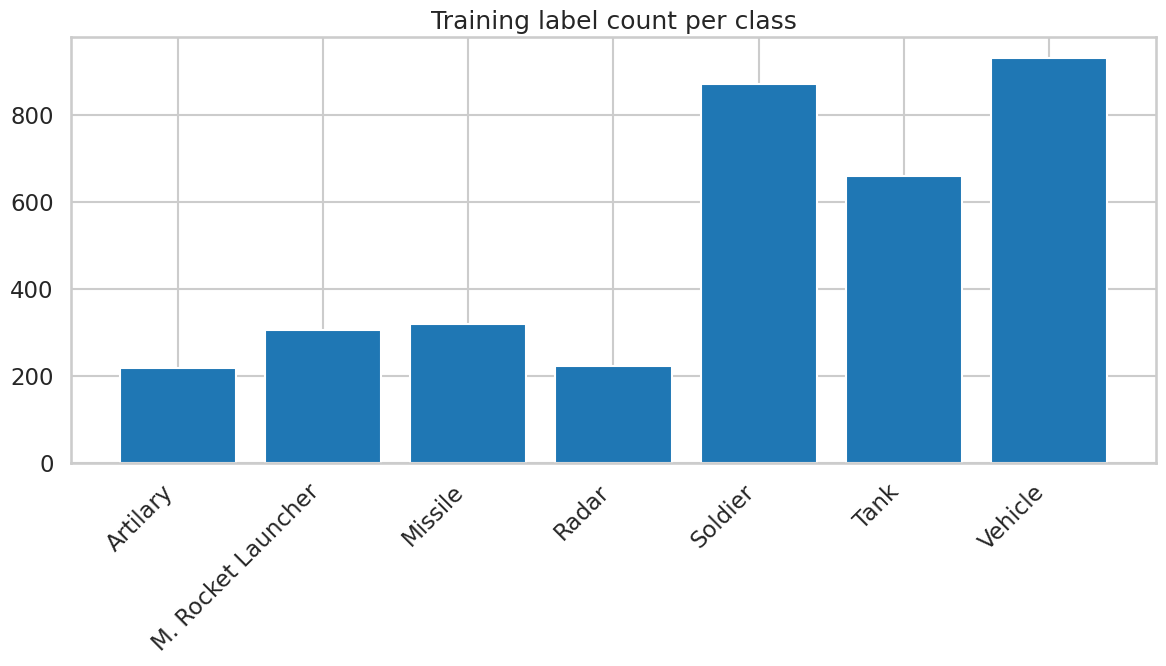

In [7]:

DATA_YAML = YOLO_DATA / "data.yaml"
yaml_dict = {
    "path": str(YOLO_DATA),
    "train": "images/train",
    "val":   "images/val",
    "test":  "images/test",
    "names": classes
}
with open(DATA_YAML, "w") as f:
    yaml.safe_dump(yaml_dict, f, sort_keys=False)

print("Wrote:", DATA_YAML)
print(yaml.safe_dump(yaml_dict, sort_keys=False))


def read_labels(lbl_dir: Path):
    counts = np.zeros(len(classes), dtype=int)
    for txt in lbl_dir.glob("*.txt"):
        with open(txt) as f:
            for line in f:
                line=line.strip()
                if not line: continue
                cls = int(line.split()[0])
                counts[cls] += 1
    return counts

train_counts = read_labels(YOLO_DATA / "labels/train")
plt.figure()
plt.bar(range(len(classes)), train_counts)
plt.xticks(range(len(classes)), classes, rotation=45, ha="right")
plt.title("Training label count per class")
plt.tight_layout(); plt.show()


# YOLOv8 Train

In [8]:

RUN8 = "yolov8s_drone"
EPOCHS   = 100
IMGSZ    = 640
BATCH    = -1   
PATIENCE = 30


try:
    model8 = YOLO("yolov8s.pt")
except Exception as e:
    print("Could not load yolov8s.pt, training from scratch:", e)
    model8 = YOLO("yolov8s.yaml")

res8 = model8.train(
    data=str(DATA_YAML),
    epochs=EPOCHS,
    imgsz=IMGSZ,
    batch=BATCH,
    device=0,
    workers=2,
    project="runs/detect",
    name=RUN8,
    verbose=True,
    
    patience=PATIENCE,
    
    optimizer="AdamW",
    lr0=0.003,     
    lrf=0.12,      
    weight_decay=5e-4,
    warmup_epochs=3,
    cos_lr=True,
    
    degrees=5.0, translate=0.10, scale=0.9, shear=2.0,
    fliplr=0.5, flipud=0.0,
    mosaic=1.0, mixup=0.10,
    erasing=0.0, copy_paste=0.0,
    close_mosaic=10,
    amp=True
)


100%|██████████| 21.5M/21.5M [00:00<00:00, 32.7MB/s]


New https://pypi.org/project/ultralytics/8.3.178 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.78 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/working/yolo_data/data.yaml, epochs=100, time=None, patience=30, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=2, project=runs/detect, name=yolov8s_drone, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, em

100%|██████████| 755k/755k [00:00<00:00, 3.80MB/s]
E0000 00:00:1755094235.943360      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755094236.001277      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=7

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 15.6MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/yolo_data/labels/train... 1301 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1301/1301 [00:02<00:00, 639.69it/s]


train: New cache created: /kaggle/working/yolo_data/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla P100-PCIE-16GB) 15.89G total, 0.15G reserved, 0.14G allocated, 15.60G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    11138309       28.66         0.879         34.48         151.4        (1, 3, 640, 640)                    list
    11138309       57.32         1.166         23.52          77.5        (2, 3, 640, 640)                    list
    11138309       114.6         1.883         27.08         126.2        (4, 3, 640, 640)                    list
    11138309       229.3         3.118          44.4         119.1 

train: Scanning /kaggle/working/yolo_data/labels/train.cache... 1301 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1301/1301 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/yolo_data/labels/val... 229 images, 0 backgrounds, 0 corrupt: 100%|██████████| 229/229 [00:00<00:00, 603.93it/s]

val: New cache created: /kaggle/working/yolo_data/labels/val.cache


Plotting labels to runs/detect/yolov8s_drone/labels.jpg... 
optimizer: AdamW(lr=0.003, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000578125), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8s_drone
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      9.18G      1.708      4.037      1.522         47        640: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]

                   all        229        639      0.143     0.0608   0.000184    5.4e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      9.12G      1.881      2.775      1.698         28        640: 100%|██████████| 36/36 [00:23<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.95s/it]

                   all        229        639   0.000456     0.0754   0.000294   9.19e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      9.13G      1.904      2.721      1.753         20        640: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]

                   all        229        639     0.0318      0.233     0.0102    0.00368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      9.13G      1.846      2.647      1.702         51        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]

                   all        229        639       0.15      0.315     0.0722     0.0294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      9.13G      1.837      2.582      1.683         40        640: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

                   all        229        639      0.308       0.24      0.103     0.0457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      9.15G      1.792      2.513      1.649         63        640: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]

                   all        229        639      0.192       0.25      0.132     0.0576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      9.13G      1.725      2.441      1.625         31        640: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

                   all        229        639      0.315      0.259      0.167     0.0794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      9.12G      1.741      2.389       1.62         38        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]

                   all        229        639      0.178      0.263      0.178     0.0836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      9.12G      1.699      2.366      1.581         16        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        229        639      0.278      0.265      0.216      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      9.12G      1.673      2.276       1.56         19        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]

                   all        229        639      0.386      0.331      0.233      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      9.12G      1.687      2.231      1.553         37        640: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all        229        639      0.245      0.374      0.283       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      9.13G      1.669      2.242      1.568         23        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]

                   all        229        639      0.274      0.275      0.205     0.0951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      9.12G      1.643      2.132      1.543         52        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

                   all        229        639      0.316      0.314      0.246      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      9.13G      1.614      2.136       1.53         55        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all        229        639        0.3      0.391      0.297      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      9.12G       1.58      2.105      1.511         29        640: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        229        639      0.298      0.408      0.307       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      9.12G      1.612      2.161      1.522         42        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]

                   all        229        639      0.337      0.385      0.317      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      9.12G       1.59      2.116      1.504         19        640: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]

                   all        229        639      0.333       0.39       0.32      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      9.12G      1.565      2.008       1.48         32        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.21it/s]

                   all        229        639      0.351      0.354      0.327      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      9.13G      1.543      2.014      1.471         40        640: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]

                   all        229        639       0.34      0.373      0.336      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      9.12G      1.526      1.989      1.473         34        640: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]

                   all        229        639      0.328      0.419      0.331      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      9.13G      1.539      1.954       1.47         38        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]

                   all        229        639      0.322      0.424      0.343       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      9.12G      1.561      1.987      1.468         29        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all        229        639      0.385      0.362      0.344      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      9.13G      1.508      1.923      1.451         25        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]

                   all        229        639      0.368      0.389      0.357      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      9.12G      1.529      1.946      1.469         23        640: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        229        639      0.416       0.35      0.334      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      9.12G      1.533      1.937      1.458         36        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]

                   all        229        639       0.28      0.385      0.319      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      9.12G      1.496      1.867      1.438         49        640: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        229        639      0.411      0.431      0.393      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      9.12G      1.477      1.846      1.428         32        640: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        229        639       0.36      0.453      0.369      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      9.13G      1.482      1.819      1.426         28        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all        229        639      0.403      0.443      0.391       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      9.12G       1.48      1.804      1.416         29        640: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        229        639      0.375      0.434      0.395      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      9.12G      1.454       1.76      1.398         33        640: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        229        639      0.519      0.385      0.393      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      9.12G       1.46      1.798      1.418         24        640: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all        229        639      0.433      0.468      0.423      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      9.13G      1.409      1.733      1.403         26        640: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

                   all        229        639      0.419      0.487      0.435      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      9.13G      1.439      1.732      1.393         42        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        229        639      0.414      0.451      0.422      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      9.13G      1.438      1.716      1.397         40        640: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all        229        639      0.486       0.47      0.457      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      9.13G       1.43      1.713      1.378         38        640: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]

                   all        229        639      0.433      0.439      0.414       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      9.13G      1.428      1.713       1.39         39        640: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all        229        639      0.366      0.528      0.435      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      9.12G      1.408      1.657      1.386         30        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

                   all        229        639      0.506      0.428       0.45      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      9.12G      1.427      1.658      1.369         57        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all        229        639      0.475       0.43      0.454      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      9.13G      1.392      1.639      1.361         23        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        229        639      0.504      0.487      0.484      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      9.13G      1.412      1.646      1.368         46        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all        229        639       0.44       0.52      0.481      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      9.13G      1.394      1.614       1.36         20        640: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all        229        639       0.48      0.432      0.471      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      9.12G      1.381      1.621      1.364         30        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        229        639      0.468      0.519      0.479      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      9.13G      1.395      1.588      1.362         24        640: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        229        639        0.5      0.505      0.508      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      9.12G      1.377      1.548      1.355         20        640: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all        229        639      0.479      0.483      0.471       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      9.13G      1.367      1.575       1.35         27        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all        229        639      0.526      0.546      0.537      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      9.12G       1.36      1.529      1.337         19        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        229        639      0.515      0.585      0.567      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      9.12G      1.376      1.527      1.358         30        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        229        639      0.473      0.537      0.502      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      9.12G      1.361      1.554      1.355         37        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        229        639      0.529      0.568      0.535      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      9.12G       1.34      1.507      1.307         24        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        229        639       0.46      0.574      0.513      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      9.13G       1.32      1.493      1.323         36        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all        229        639      0.515      0.542      0.548      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      9.12G      1.306      1.442      1.307         22        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

                   all        229        639      0.466      0.568      0.529      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      9.13G      1.331      1.463      1.313         29        640: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        229        639      0.468      0.597      0.552      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      9.12G      1.341      1.414      1.298         78        640: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        229        639      0.583      0.527      0.565      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      9.13G       1.31      1.417      1.297         52        640: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all        229        639        0.5      0.593      0.568      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      9.12G      1.298      1.401      1.281         37        640: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all        229        639      0.531       0.58      0.558       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      9.12G       1.31       1.41      1.291         46        640: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]

                   all        229        639      0.448       0.62      0.548       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      9.12G      1.303      1.392      1.293         35        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        229        639      0.556      0.587      0.586      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      9.12G      1.292      1.377      1.282         29        640: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all        229        639      0.514      0.604      0.556      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      9.13G      1.286      1.381      1.295         51        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        229        639      0.563      0.578       0.58      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      9.12G      1.282      1.347      1.272         42        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        229        639      0.563      0.578      0.608      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      9.12G      1.279      1.396      1.281         35        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        229        639      0.542      0.576      0.573      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      9.12G      1.281      1.339      1.278         20        640: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        229        639      0.607      0.564      0.586      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      9.13G      1.256      1.312      1.263         36        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        229        639      0.517      0.625      0.576      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      9.13G       1.27      1.341      1.277         20        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all        229        639      0.554      0.564      0.572      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      9.13G      1.266      1.327      1.272         46        640: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        229        639      0.615      0.596      0.611      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      9.13G      1.232      1.275      1.247         34        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]

                   all        229        639      0.634      0.575      0.604      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      9.13G      1.272      1.272      1.265         50        640: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all        229        639      0.571      0.647      0.629      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      9.12G      1.262      1.287      1.265         47        640: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        229        639      0.636       0.59      0.613      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      9.12G       1.23      1.253      1.247         49        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]

                   all        229        639      0.642      0.549      0.628      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      9.13G      1.234      1.239       1.25         28        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all        229        639      0.578      0.657       0.63      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      9.13G      1.225      1.225      1.233         40        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all        229        639      0.548      0.656      0.615      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      9.13G      1.233      1.232      1.251         43        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all        229        639      0.589      0.645      0.631      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      9.12G      1.207      1.219      1.227         45        640: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all        229        639      0.542      0.641      0.622      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      9.13G      1.221      1.205      1.236         80        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        229        639      0.624      0.626      0.625      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      9.12G      1.228       1.21      1.254         44        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]

                   all        229        639      0.575      0.625      0.616      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      9.13G      1.206      1.207      1.232         28        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]

                   all        229        639      0.617      0.623      0.619      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      9.12G      1.186      1.162      1.222         24        640: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        229        639       0.57      0.641      0.632      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      9.12G      1.216      1.219      1.235         27        640: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]

                   all        229        639      0.658      0.624      0.651      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      9.12G      1.177      1.169      1.219         36        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all        229        639      0.618      0.644      0.632      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      9.12G      1.186      1.153      1.209         35        640: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]

                   all        229        639      0.652       0.62      0.644      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      9.13G      1.201      1.138      1.221         39        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all        229        639      0.638      0.622      0.663      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      9.12G      1.184      1.136        1.2         26        640: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.21it/s]

                   all        229        639      0.639      0.653      0.655      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      9.13G      1.168      1.142      1.216         34        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all        229        639       0.67      0.612      0.652      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      9.12G      1.178      1.103      1.205         33        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all        229        639      0.681      0.601      0.666       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      9.13G      1.196       1.12      1.215         22        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all        229        639      0.667      0.632      0.657      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      9.12G      1.167      1.069      1.188         37        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        229        639      0.622      0.639       0.65      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      9.12G      1.152      1.086       1.19         64        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]

                   all        229        639      0.681      0.672      0.692      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      9.12G      1.182      1.097      1.205         55        640: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        229        639      0.692      0.614      0.671      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      9.12G      1.164      1.071      1.196         40        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]

                   all        229        639      0.609      0.682      0.677      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      9.13G      1.155      1.071      1.186         63        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        229        639      0.652      0.654      0.671      0.394


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      9.12G      1.069     0.9633      1.197         16        640: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        229        639      0.663      0.652       0.68      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      9.12G      1.051     0.8806      1.179          9        640: 100%|██████████| 36/36 [00:22<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        229        639      0.678      0.647      0.678      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      9.12G      1.042     0.8646      1.165         16        640: 100%|██████████| 36/36 [00:22<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all        229        639      0.708      0.658       0.69       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      9.13G      1.047     0.8628      1.172         19        640: 100%|██████████| 36/36 [00:22<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]

                   all        229        639      0.676      0.632      0.675      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      9.13G      1.049     0.8781      1.178         11        640: 100%|██████████| 36/36 [00:22<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        229        639      0.631      0.663      0.672      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      9.13G      1.049     0.8567      1.173         21        640: 100%|██████████| 36/36 [00:22<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all        229        639      0.672       0.65       0.66      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      9.13G      1.038     0.8272      1.168         18        640: 100%|██████████| 36/36 [00:22<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        229        639      0.669      0.635      0.681      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      9.13G       1.01     0.8187      1.145         15        640: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        229        639      0.629      0.668      0.665      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      9.12G      1.012     0.8194      1.149          8        640: 100%|██████████| 36/36 [00:22<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        229        639      0.688       0.64      0.677      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      9.12G      1.031     0.8103      1.144          6        640: 100%|██████████| 36/36 [00:22<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all        229        639      0.698      0.615      0.682      0.389



100 epochs completed in 0.714 hours.
Optimizer stripped from runs/detect/yolov8s_drone/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/yolov8s_drone/weights/best.pt, 22.5MB

Validating runs/detect/yolov8s_drone/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 11,128,293 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]


                   all        229        639      0.708      0.659       0.69       0.41
              Artilary         28         45      0.851      0.507      0.662      0.317
    M. Rocket Launcher         29         36      0.589       0.75      0.671      0.503
               Missile         49         92       0.72      0.696      0.719      0.468
                 Radar         27         30      0.558      0.533      0.521      0.239
               Soldier         50        160      0.809      0.619      0.704      0.354
                  Tank         47        118      0.769      0.763      0.813      0.501
               Vehicle         69        158      0.662      0.743      0.739      0.489


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 4.4ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/yolov8s_drone


# YOLOv12

In [9]:

RUN12 = "yolov12s_drone"


model12 = None
err = None
for candidate in ["yolov12s.pt", "yolo12s.pt"]: 
    try:
        model12 = YOLO(candidate)
        print("Loaded:", candidate)
        break
    except Exception as e:
        err = e
        continue

if model12 is None:
    try:
        model12 = YOLO("yolov12s.yaml")
        print("Loaded config: yolov12s.yaml (training from scratch)")
    except Exception as e2:
        print("Could not load YOLOv12 weights/config automatically.")
        print("Last errors:", err, e2)
        raise RuntimeError(
            "Your Ultralytics build may not include YOLOv12. "
            "Upgrade ultralytics to a version that supports YOLO12 or provide "
            "local weights/config via OFFLINE_WHEELS_DIR."
        )

res12 = model12.train(
    data=str(DATA_YAML),
    epochs=EPOCHS,
    imgsz=IMGSZ,
    batch=BATCH,
    device=0,
    workers=2,
    project="runs/detect",
    name=RUN12,
    verbose=True,
    patience=PATIENCE,
    optimizer="AdamW",
    lr0=0.003, lrf=0.12, weight_decay=5e-4, warmup_epochs=3, cos_lr=True,
    degrees=5.0, translate=0.10, scale=0.9, shear=2.0,
    fliplr=0.5, flipud=0.0,
    mosaic=1.0, mixup=0.10, erasing=0.0, copy_paste=0.0,
    close_mosaic=10,
    amp=True
)


100%|██████████| 18.1M/18.1M [00:00<00:00, 27.8MB/s]


Loaded: yolo12s.pt
New https://pypi.org/project/ultralytics/8.3.178 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.78 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo12s.pt, data=/kaggle/working/yolo_data/data.yaml, epochs=100, time=None, patience=30, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=2, project=runs/detect, name=yolov12s_drone, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, re

train: Scanning /kaggle/working/yolo_data/labels/train.cache... 1301 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1301/1301 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla P100-PCIE-16GB) 15.89G total, 0.54G reserved, 0.27G allocated, 15.07G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output


     9255845       21.53         1.426         55.52         241.7        (1, 3, 640, 640)                    list
     9255845       43.07         1.896         47.56         242.4        (2, 3, 640, 640)                    list
     9255845       86.14         2.831         49.66         273.2        (4, 3, 640, 640)                    list
     9255845       172.3         4.473         72.71         345.4        (8, 3, 640, 640)                    list
     9255845       344.6         8.089         137.6         483.5       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 22 for CUDA:0 9.75G/15.89G (61%) ✅


train: Scanning /kaggle/working/yolo_data/labels/train.cache... 1301 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1301/1301 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/yolo_data/labels/val.cache... 229 images, 0 backgrounds, 0 corrupt: 100%|██████████| 229/229 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov12s_drone/labels.jpg... 
optimizer: AdamW(lr=0.003, momentum=0.937) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.000515625), 119 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolov12s_drone
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      8.88G      1.849      3.359      1.742         25        640: 100%|██████████| 60/60 [00:49<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/engine/validator.py:255: RuntimeWarning: invalid value encountered in greater_equal
  matches = np.nonzero(iou >= threshold)  # IoU > threshold and classes match
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.43it/s]


                   all        229        639    0.00683     0.0166    0.00113   0.000382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      8.75G      1.972      2.925      1.888         19        640: 100%|██████████| 60/60 [00:48<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.42it/s]

                   all        229        639     0.0196      0.162    0.00706    0.00266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      8.71G      2.022      2.949      1.923         19        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.62it/s]

                   all        229        639     0.0454      0.099     0.0204    0.00894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      8.61G      1.967      2.922      1.881          9        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        229        639     0.0931      0.151     0.0533     0.0207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      8.69G      1.945      2.789      1.836         15        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.58it/s]

                   all        229        639      0.262      0.225      0.114     0.0431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       8.6G      1.861      2.729      1.819          7        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.39it/s]

                   all        229        639      0.303      0.134     0.0879     0.0393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      8.69G      1.788      2.648      1.753         12        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.61it/s]

                   all        229        639      0.449      0.156      0.135     0.0637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      8.72G      1.808      2.602      1.755         28        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.62it/s]

                   all        229        639      0.288      0.217      0.137     0.0646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      8.72G      1.785      2.564      1.745         13        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.64it/s]

                   all        229        639      0.304      0.201      0.165     0.0751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      8.67G      1.771      2.528      1.718          6        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.65it/s]

                   all        229        639      0.223      0.247       0.19     0.0895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      8.72G      1.739        2.5      1.706         18        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.67it/s]

                   all        229        639      0.218      0.278      0.173     0.0773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      8.71G      1.756      2.444      1.675         18        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.60it/s]

                   all        229        639      0.127      0.297      0.139     0.0553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      8.76G      1.751      2.434      1.699         10        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.68it/s]

                   all        229        639      0.214      0.265      0.187     0.0831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100       8.7G      1.719      2.434      1.689         19        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all        229        639      0.365      0.266        0.2     0.0948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      8.76G      1.708      2.412      1.683         22        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.67it/s]

                   all        229        639      0.191      0.272      0.174     0.0859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      8.56G      1.663      2.388      1.629         14        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.65it/s]

                   all        229        639      0.226      0.311      0.201     0.0956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      8.84G      1.686      2.323      1.643         34        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.63it/s]

                   all        229        639      0.278      0.288      0.224       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      8.56G      1.686      2.325      1.652         41        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.68it/s]

                   all        229        639      0.377      0.295      0.263      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100       8.7G      1.652      2.233      1.615         10        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.70it/s]

                   all        229        639      0.253      0.343      0.231      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      8.71G      1.662      2.291      1.642         18        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.63it/s]

                   all        229        639        0.2      0.327      0.215      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      8.84G      1.663      2.252      1.632         18        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.60it/s]

                   all        229        639      0.346      0.341      0.235       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      8.71G      1.624      2.232      1.601         15        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.68it/s]

                   all        229        639      0.272      0.347      0.246       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100       8.8G      1.612      2.209      1.587         11        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.69it/s]

                   all        229        639      0.285      0.348      0.242      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      8.73G      1.604      2.142      1.579         14        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.73it/s]

                   all        229        639      0.258      0.391      0.288      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      8.73G      1.602      2.163       1.56         12        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.69it/s]

                   all        229        639       0.27       0.39      0.315      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      8.72G      1.575      2.138      1.556         48        640: 100%|██████████| 60/60 [00:48<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.71it/s]

                   all        229        639      0.325      0.389      0.288      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      8.85G       1.56      2.091      1.553         15        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]

                   all        229        639      0.315      0.307      0.261      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      8.71G      1.609      2.124      1.573         11        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.68it/s]

                   all        229        639      0.297      0.422      0.307      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      8.71G      1.577      2.108      1.556         16        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.72it/s]

                   all        229        639      0.318      0.372      0.324       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      8.72G      1.559      2.059      1.563         18        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.65it/s]

                   all        229        639      0.287       0.43      0.325       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      8.67G      1.549      2.043      1.528         18        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.69it/s]

                   all        229        639      0.344      0.397      0.308      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      8.67G      1.527      1.985      1.534         17        640: 100%|██████████| 60/60 [00:48<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.71it/s]

                   all        229        639      0.585      0.311      0.357       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      8.67G      1.523      2.006      1.531          4        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.65it/s]

                   all        229        639      0.325      0.419      0.332      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      8.71G      1.507      1.966      1.534         35        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.76it/s]

                   all        229        639       0.35      0.383      0.337      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      8.68G       1.55      1.981      1.517         21        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.79it/s]

                   all        229        639      0.419      0.409      0.367      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      8.68G       1.55       1.97      1.545         17        640: 100%|██████████| 60/60 [00:48<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.72it/s]

                   all        229        639      0.396      0.453      0.377      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      8.71G      1.531      1.988      1.524         18        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.66it/s]

                   all        229        639      0.412      0.437      0.381      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      8.67G      1.536      1.947      1.516         23        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.76it/s]

                   all        229        639      0.419      0.402      0.368      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100       8.6G      1.533      1.947      1.515         44        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.68it/s]

                   all        229        639      0.297      0.425      0.336      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      8.68G      1.487      1.903       1.49          9        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.72it/s]

                   all        229        639      0.432       0.41      0.375      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      8.67G      1.485      1.875      1.483         19        640: 100%|██████████| 60/60 [00:48<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.69it/s]

                   all        229        639      0.428      0.411      0.394      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      8.68G      1.485      1.884      1.492         15        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.68it/s]

                   all        229        639       0.42      0.425      0.414       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      8.69G      1.483      1.852      1.484         26        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.67it/s]

                   all        229        639      0.362      0.456      0.416      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      8.58G      1.485      1.833      1.466         19        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.72it/s]

                   all        229        639       0.41      0.462      0.413      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100       8.7G      1.456      1.816      1.464         14        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.68it/s]

                   all        229        639      0.422      0.445      0.385      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      8.69G      1.457      1.812      1.475         12        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]

                   all        229        639      0.423      0.439      0.422      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      8.68G      1.458      1.782      1.471          7        640: 100%|██████████| 60/60 [00:48<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]

                   all        229        639      0.425      0.477      0.424      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      8.84G      1.472      1.809      1.472         17        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.72it/s]

                   all        229        639      0.405      0.448      0.426      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100       8.7G      1.441      1.767      1.446          9        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.62it/s]

                   all        229        639       0.47      0.378      0.416      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      8.58G      1.425      1.742      1.449         11        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.73it/s]

                   all        229        639      0.486      0.452       0.45      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100       8.7G      1.431      1.744      1.432         29        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]

                   all        229        639      0.469       0.46      0.468      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      8.69G      1.441      1.737      1.449         18        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.72it/s]

                   all        229        639      0.432      0.463      0.443      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      8.72G      1.437      1.723      1.442         26        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.72it/s]

                   all        229        639      0.538      0.467      0.451      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100       8.7G       1.42      1.696      1.441         18        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.70it/s]

                   all        229        639      0.479      0.505      0.475      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      8.69G      1.401      1.691      1.419         28        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.70it/s]

                   all        229        639      0.467      0.494      0.463      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      8.72G      1.392      1.697      1.412         13        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.73it/s]

                   all        229        639      0.525      0.417      0.451      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      8.84G      1.419      1.736      1.435          3        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.72it/s]

                   all        229        639      0.426      0.468      0.428      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      8.58G      1.384      1.655      1.419         22        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.76it/s]

                   all        229        639       0.48      0.462       0.47      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      8.71G      1.391      1.651      1.411         28        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.70it/s]

                   all        229        639      0.466      0.491      0.492       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      8.72G       1.39       1.65      1.401         17        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.72it/s]

                   all        229        639      0.484      0.516      0.503      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      8.68G      1.382      1.628      1.405         25        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.75it/s]

                   all        229        639      0.418      0.549      0.477      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       8.6G      1.383      1.605      1.404         23        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.71it/s]

                   all        229        639      0.409      0.484       0.45      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      8.59G      1.378      1.577      1.395         26        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]

                   all        229        639      0.495      0.497      0.489      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      8.68G       1.35      1.554      1.374         15        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.71it/s]

                   all        229        639      0.571      0.517      0.521        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      8.71G      1.358      1.597      1.395         15        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.70it/s]

                   all        229        639      0.524      0.512      0.522        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      8.69G      1.371      1.567      1.376         28        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.77it/s]

                   all        229        639      0.442       0.51      0.502      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      8.68G      1.355      1.565      1.381         11        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]

                   all        229        639      0.502      0.503      0.487      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      8.58G      1.363      1.522      1.382         21        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]

                   all        229        639      0.573        0.5      0.527        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      8.69G      1.381      1.578      1.398         25        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.71it/s]

                   all        229        639      0.526      0.525       0.52      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      8.72G      1.338      1.541      1.372         37        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.71it/s]

                   all        229        639      0.476      0.535      0.515      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      8.68G      1.323       1.51      1.362         18        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.71it/s]

                   all        229        639      0.564      0.521      0.543      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      8.69G       1.34      1.544       1.38         19        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.76it/s]

                   all        229        639      0.553      0.522      0.555      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      8.68G      1.322      1.482      1.359         19        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.67it/s]

                   all        229        639      0.516      0.543       0.53      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      8.69G      1.337      1.512      1.378          7        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.72it/s]

                   all        229        639       0.53      0.575      0.537      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      8.68G      1.336      1.505      1.374         23        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.77it/s]

                   all        229        639      0.594      0.564      0.572      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      8.68G      1.309      1.498       1.36          5        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.75it/s]

                   all        229        639      0.573      0.525      0.554      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      8.68G      1.309      1.501      1.356         15        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]

                   all        229        639      0.513      0.549      0.542      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      8.58G      1.322      1.473      1.355         18        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.79it/s]

                   all        229        639      0.537      0.594      0.557      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      8.68G      1.322      1.477       1.37         20        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.77it/s]

                   all        229        639      0.461      0.595      0.522      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      8.68G      1.296      1.409      1.336         19        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.76it/s]

                   all        229        639      0.531      0.586      0.552      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      8.72G      1.299      1.431      1.363         10        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]

                   all        229        639      0.568      0.539      0.579      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      8.72G      1.319      1.426       1.36         10        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.77it/s]

                   all        229        639      0.491      0.593      0.557      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      8.67G      1.305      1.415      1.334         20        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.76it/s]

                   all        229        639      0.541      0.603      0.597      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      8.59G      1.281      1.362      1.317         13        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.67it/s]

                   all        229        639      0.614      0.563      0.592      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      8.57G      1.283      1.379      1.323         19        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.76it/s]

                   all        229        639      0.599      0.571      0.586      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      8.68G      1.274      1.375      1.317         11        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]

                   all        229        639      0.605      0.561      0.586      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      8.72G      1.305      1.408      1.331         12        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        229        639      0.565       0.56      0.587      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      8.68G      1.283      1.386      1.326          9        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]

                   all        229        639      0.583      0.544      0.574      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      8.68G      1.281      1.372       1.32         20        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.75it/s]

                   all        229        639      0.578      0.588      0.591      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      8.72G      1.264      1.354      1.329         14        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.75it/s]

                   all        229        639      0.542      0.608       0.59      0.343


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      8.68G      1.177      1.251      1.335         11        640: 100%|██████████| 60/60 [00:48<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.73it/s]

                   all        229        639      0.606       0.57      0.593      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      8.69G      1.188      1.223      1.341          9        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]

                   all        229        639      0.582      0.602      0.602      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      8.69G      1.189      1.177       1.32          8        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        229        639      0.609      0.576      0.594      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100       8.6G      1.181      1.155       1.31          6        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]

                   all        229        639      0.585      0.602      0.613      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      8.69G       1.17      1.139      1.313          3        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]

                   all        229        639       0.57       0.63      0.608      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      8.68G      1.133      1.113      1.299          4        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        229        639      0.622       0.57      0.606      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      8.68G       1.16      1.095       1.31         10        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        229        639        0.6        0.6      0.613      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      8.69G      1.155      1.107      1.305         11        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]

                   all        229        639      0.559      0.617      0.611      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      8.69G       1.16      1.141      1.304          3        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        229        639      0.599      0.602      0.611      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100       8.6G      1.151      1.089        1.3          3        640: 100%|██████████| 60/60 [00:48<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        229        639      0.636       0.58      0.637      0.363



100 epochs completed in 1.449 hours.
Optimizer stripped from runs/detect/yolov12s_drone/weights/last.pt, 18.9MB
Optimizer stripped from runs/detect/yolov12s_drone/weights/best.pt, 18.9MB

Validating runs/detect/yolov12s_drone/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv12s summary (fused): 159 layers, 9,233,589 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.97it/s]


                   all        229        639      0.601      0.601      0.613      0.369
              Artilary         28         45      0.666      0.532      0.581      0.296
    M. Rocket Launcher         29         36       0.47      0.518      0.517      0.391
               Missile         49         92      0.646      0.587      0.645      0.429
                 Radar         27         30      0.447        0.5      0.421      0.185
               Soldier         50        160      0.718       0.59      0.675      0.354
                  Tank         47        118      0.615      0.737      0.729      0.441
               Vehicle         69        158      0.647      0.741      0.721      0.486


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 6.8ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/yolov12s_drone


# Plot of results

Run dir: runs/detect/yolov8s_drone


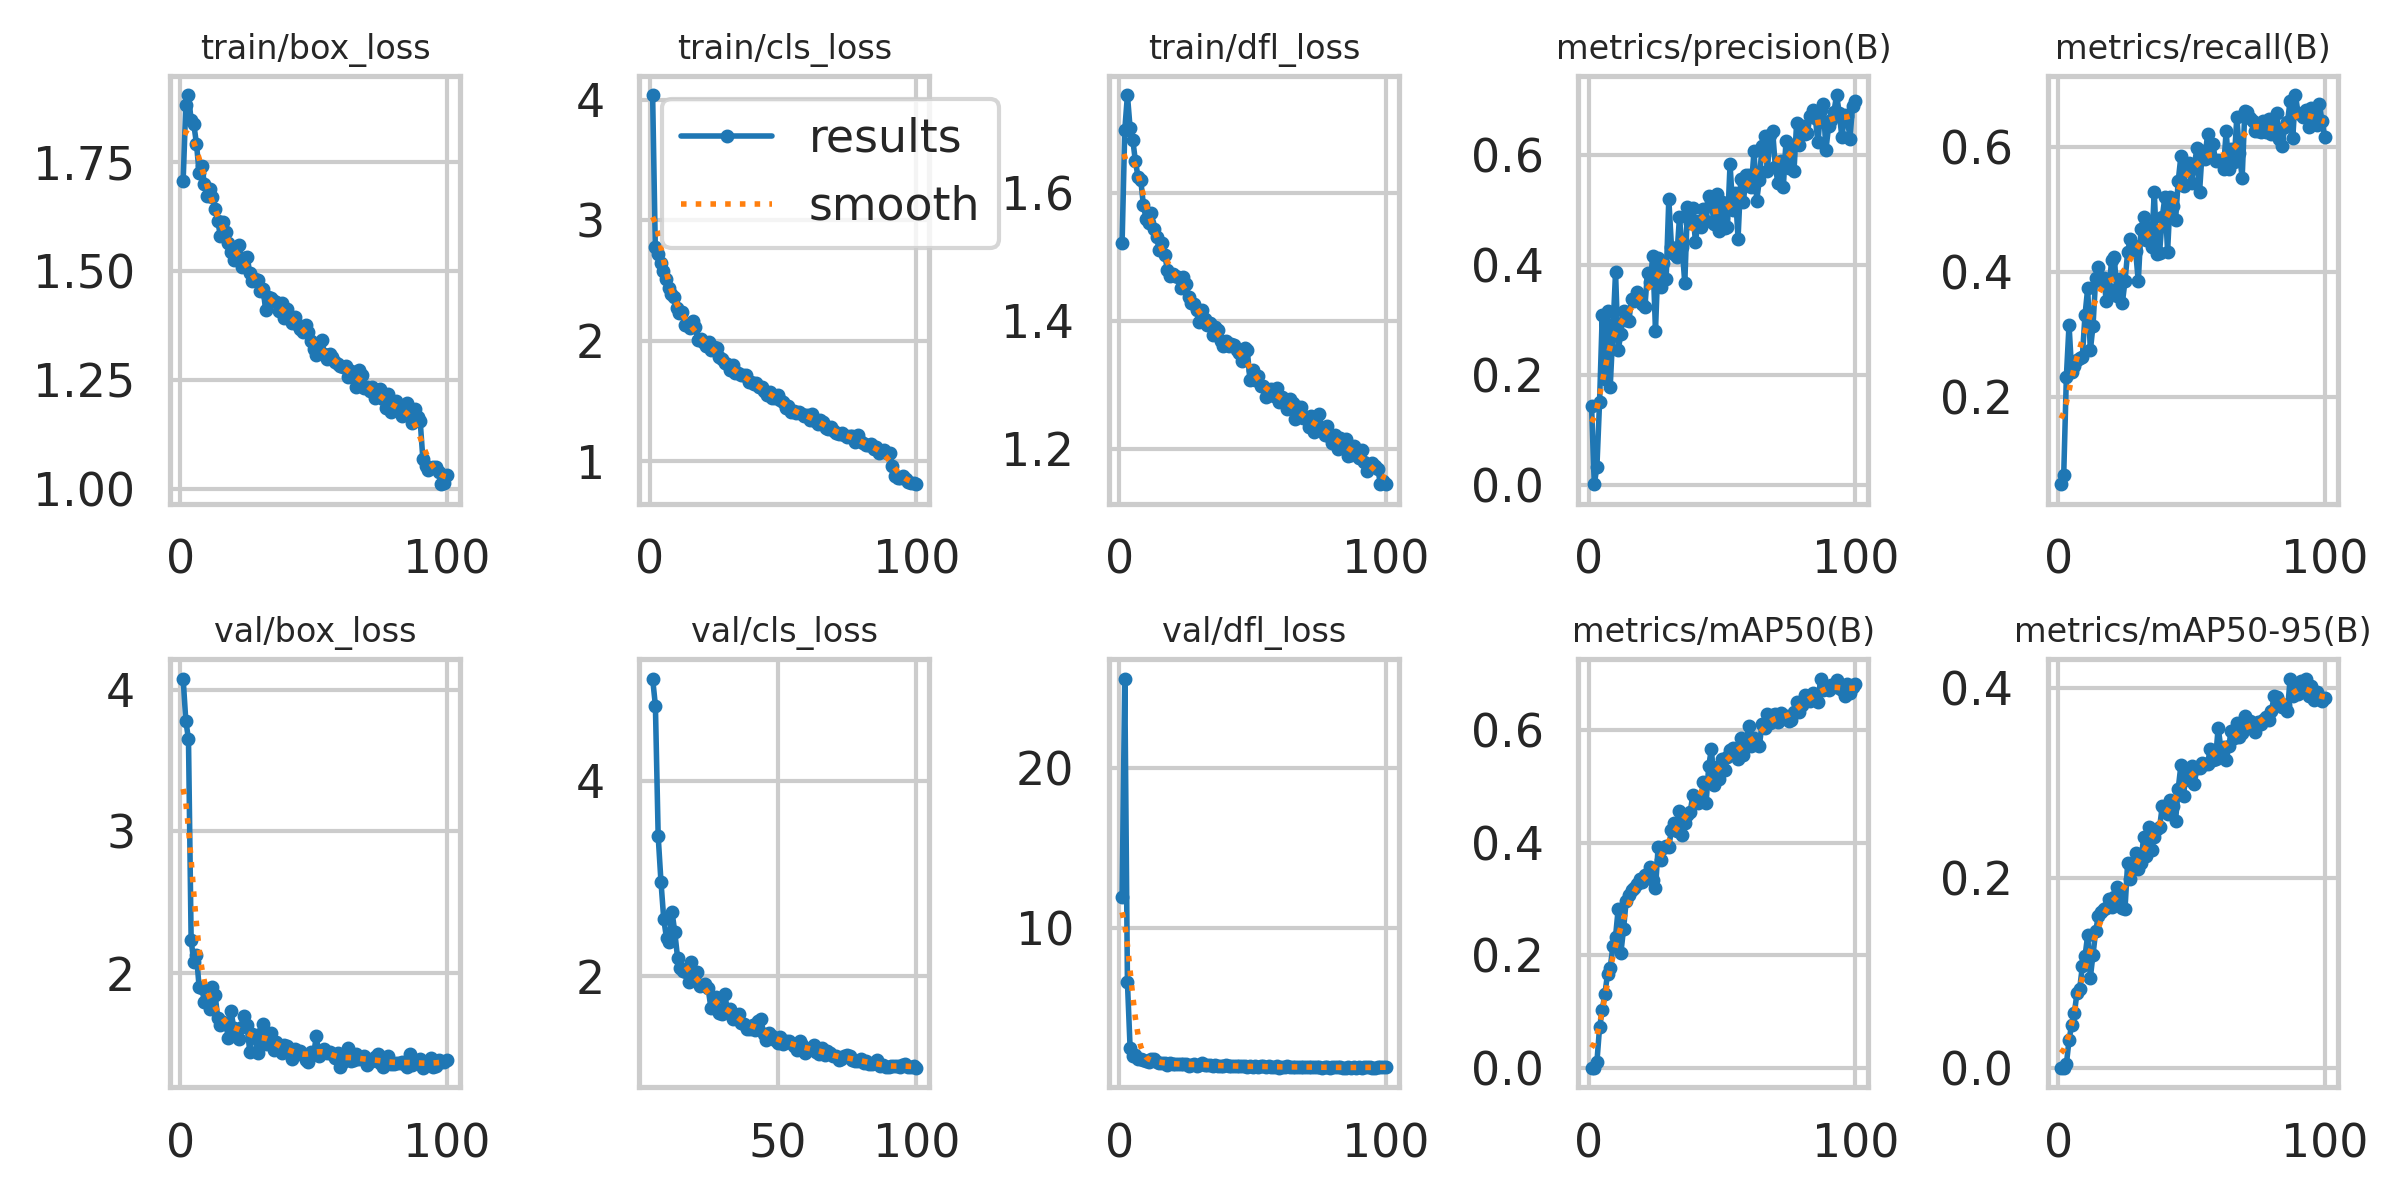

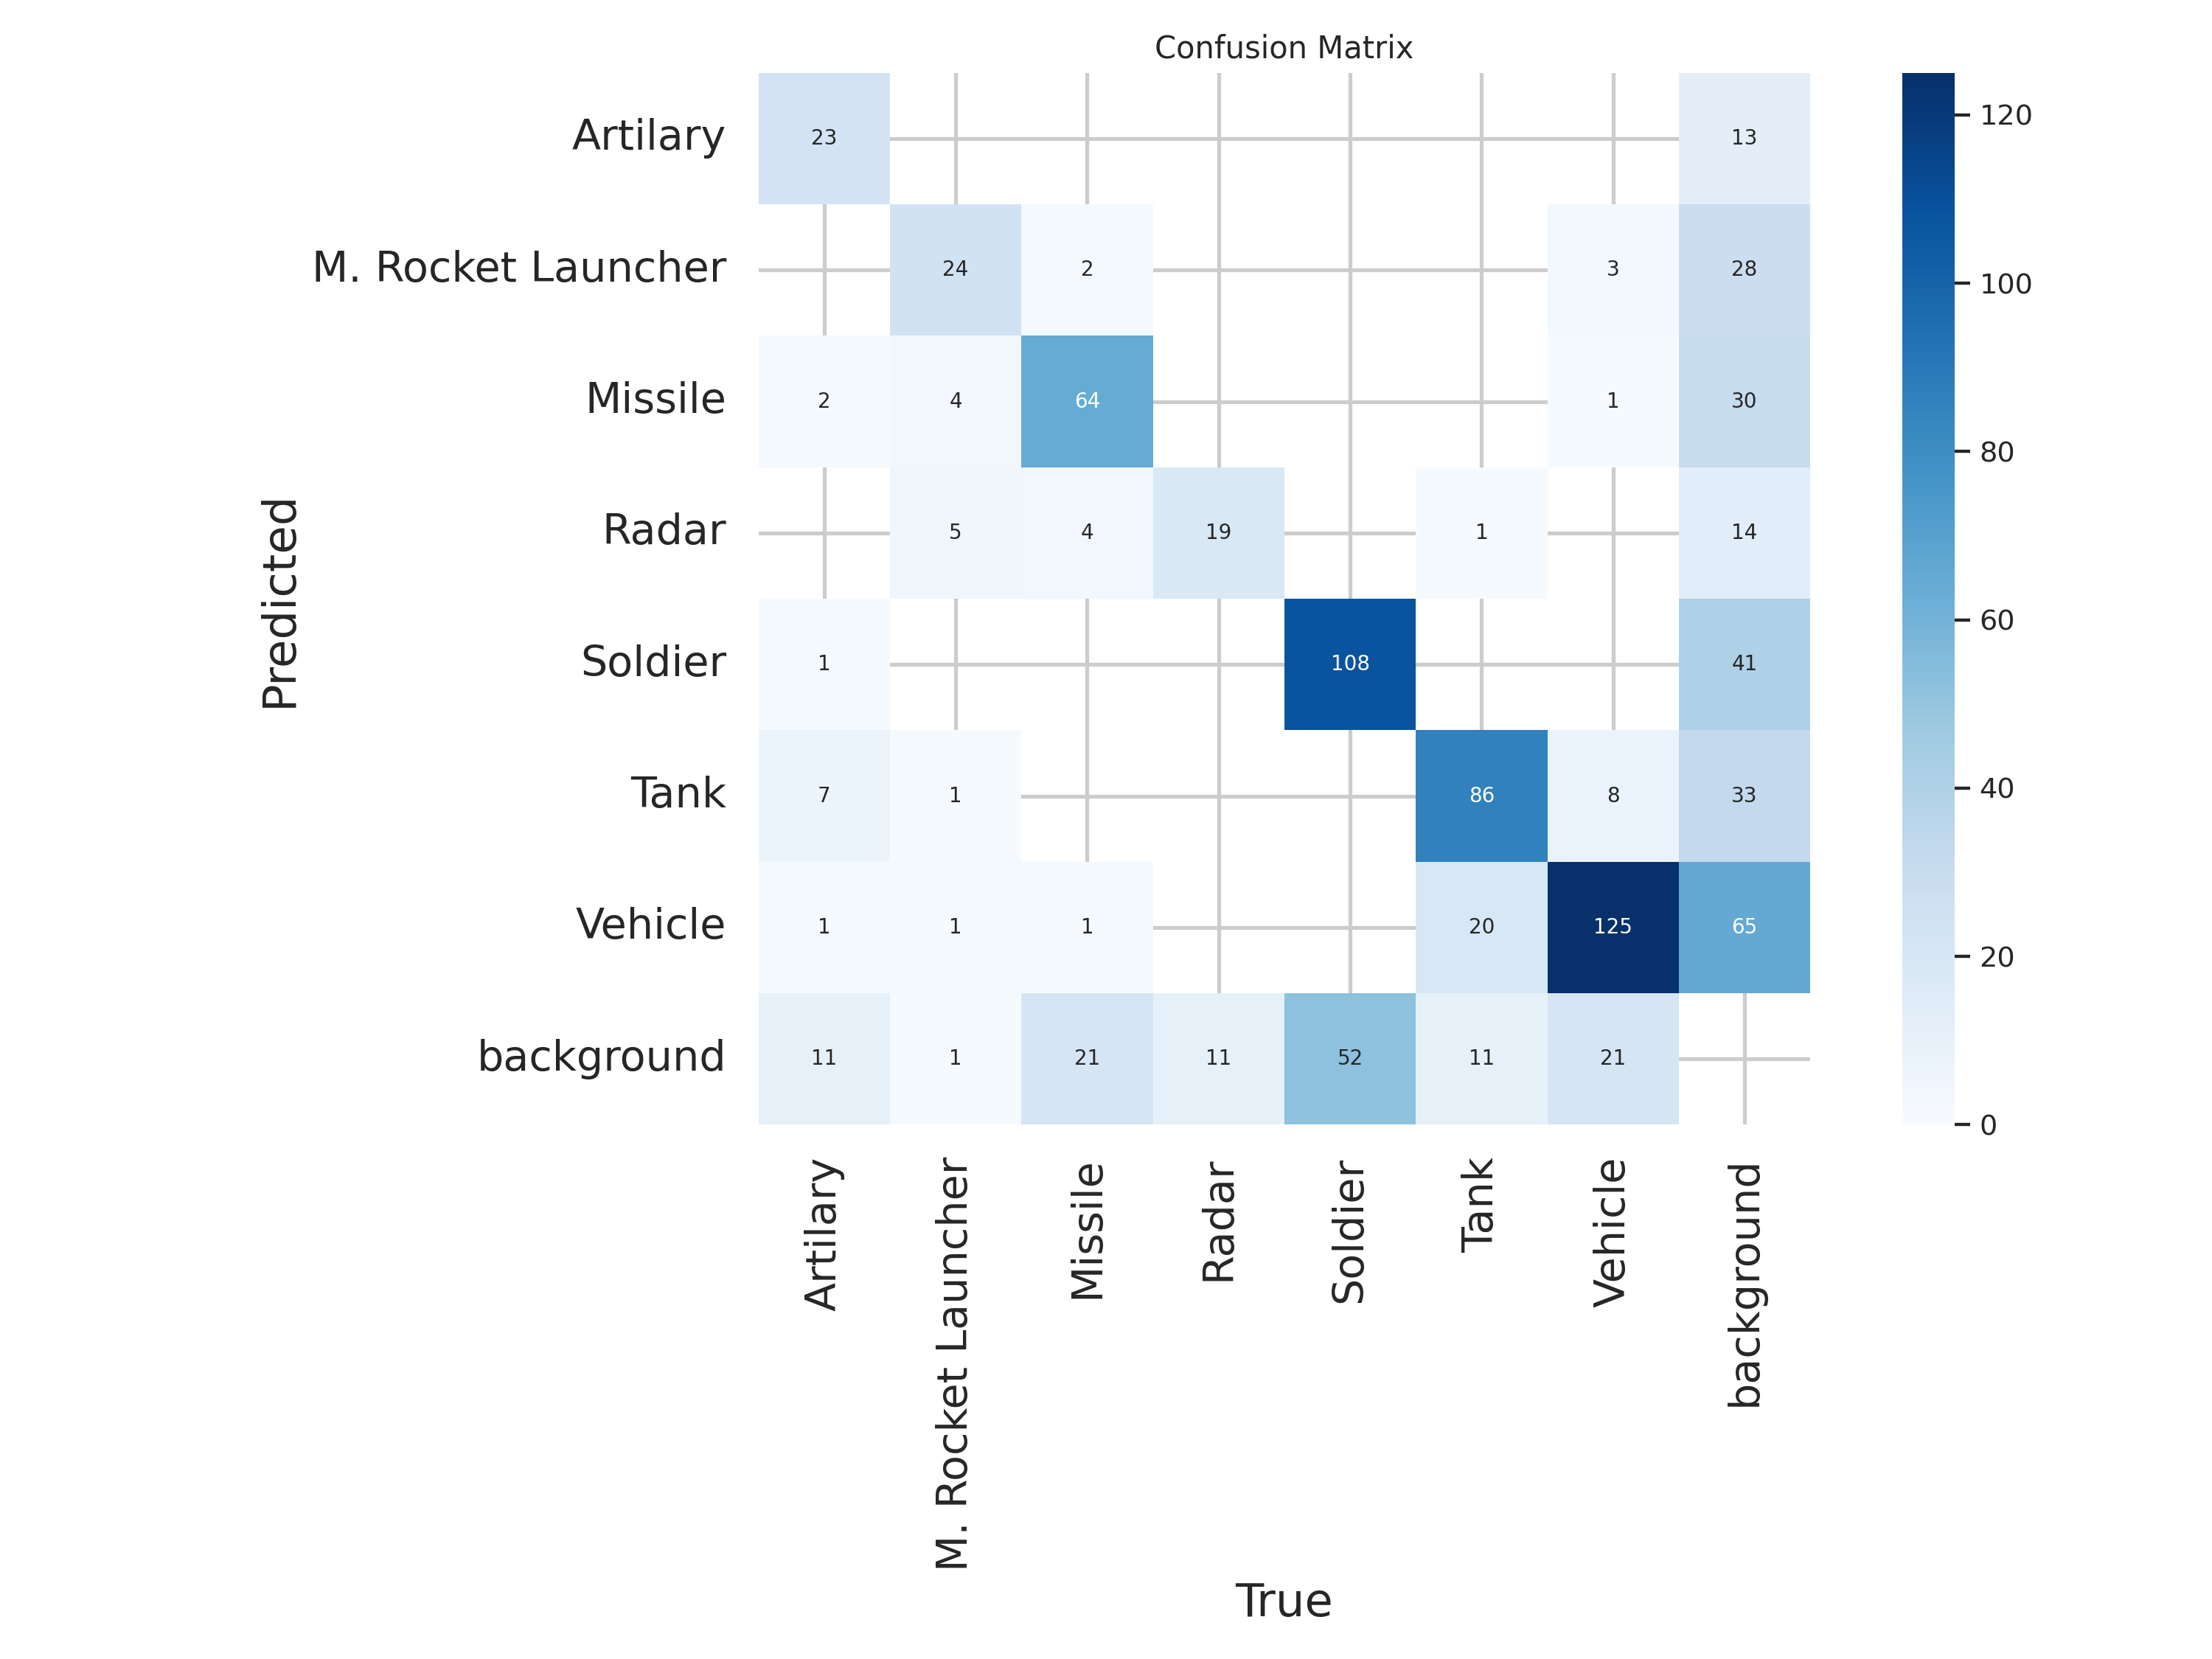

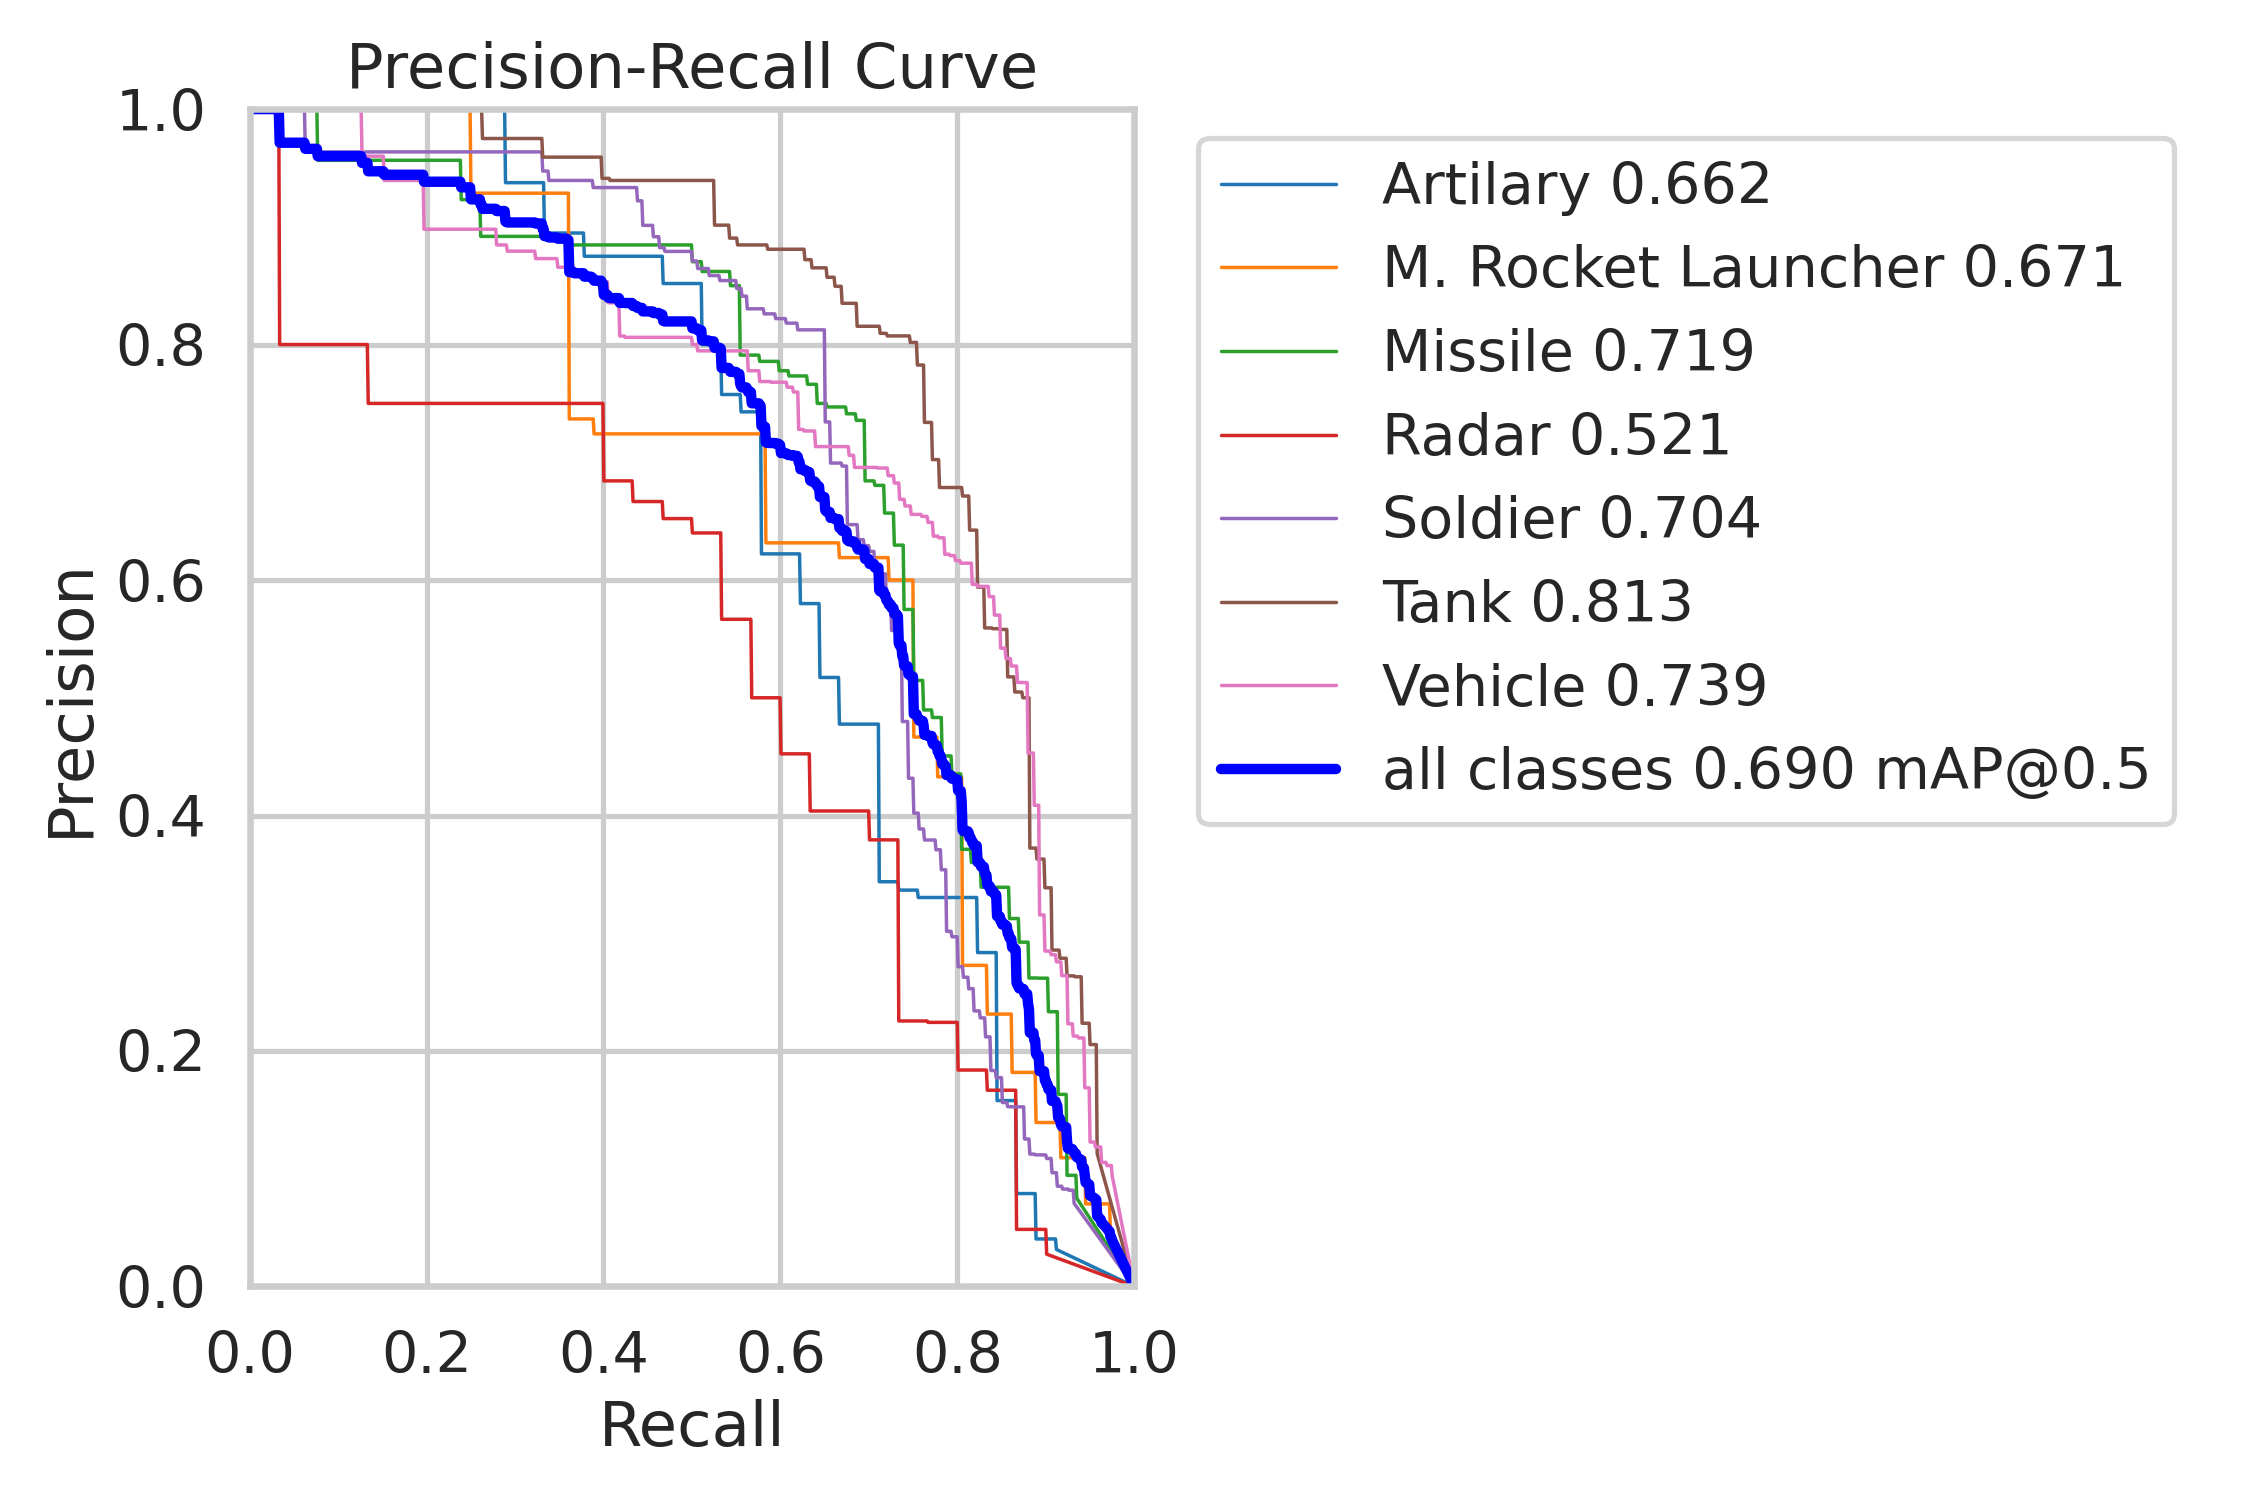

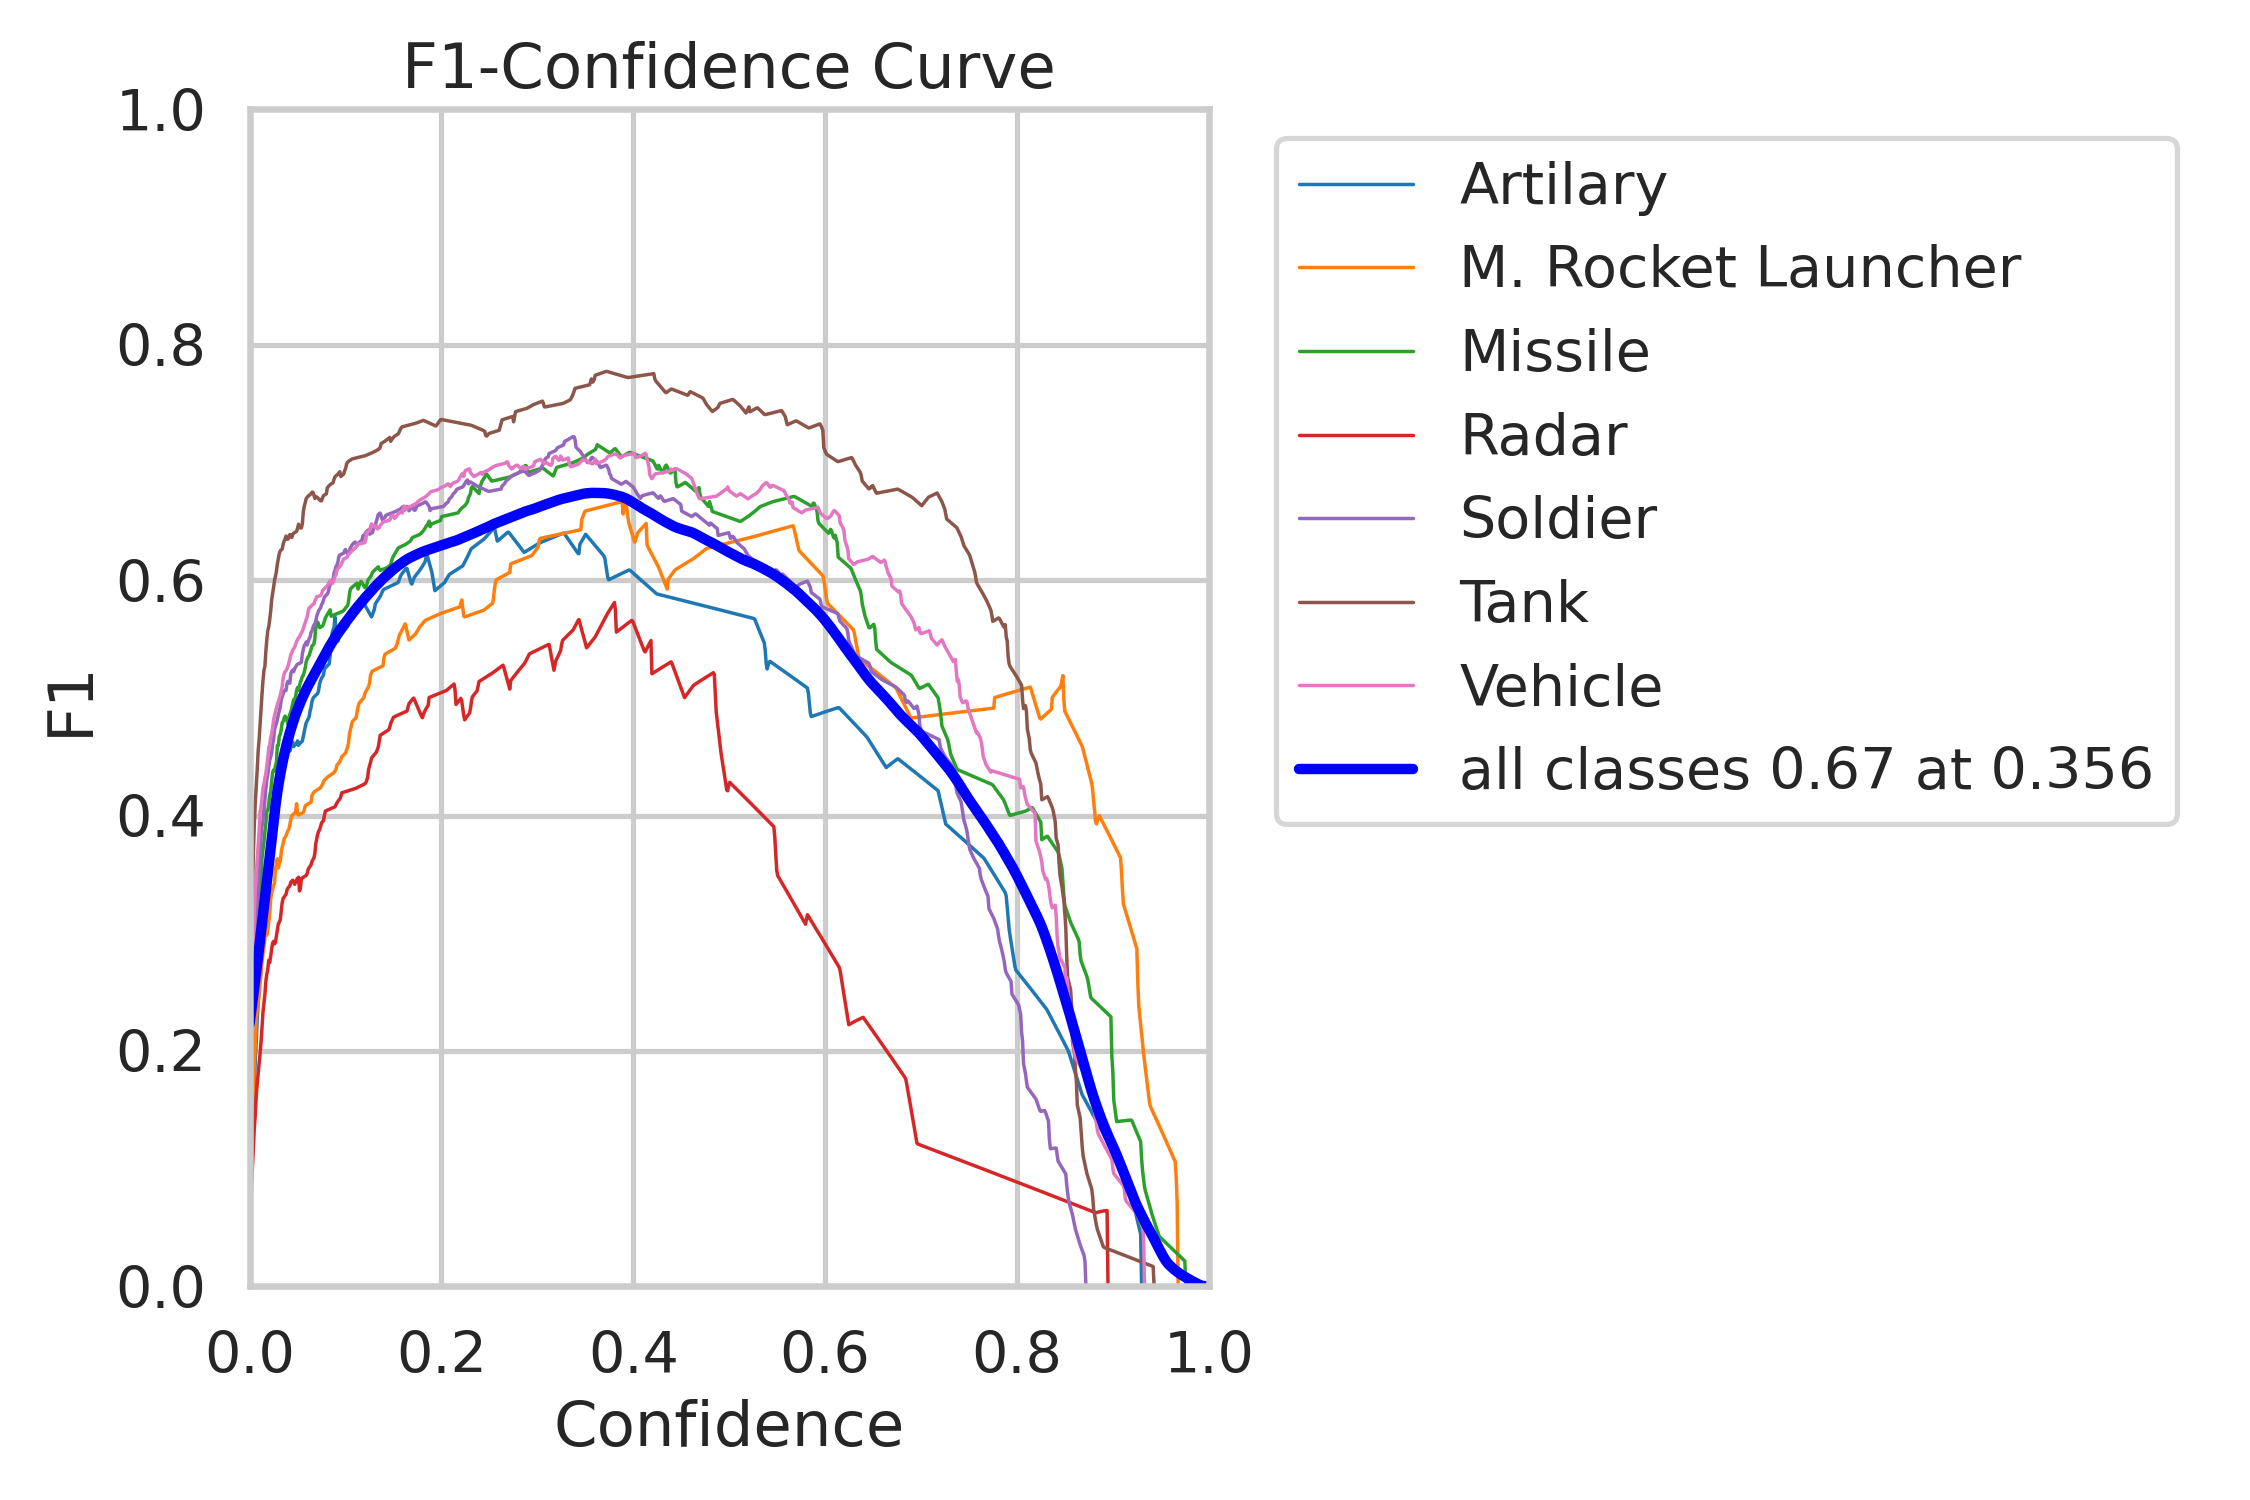

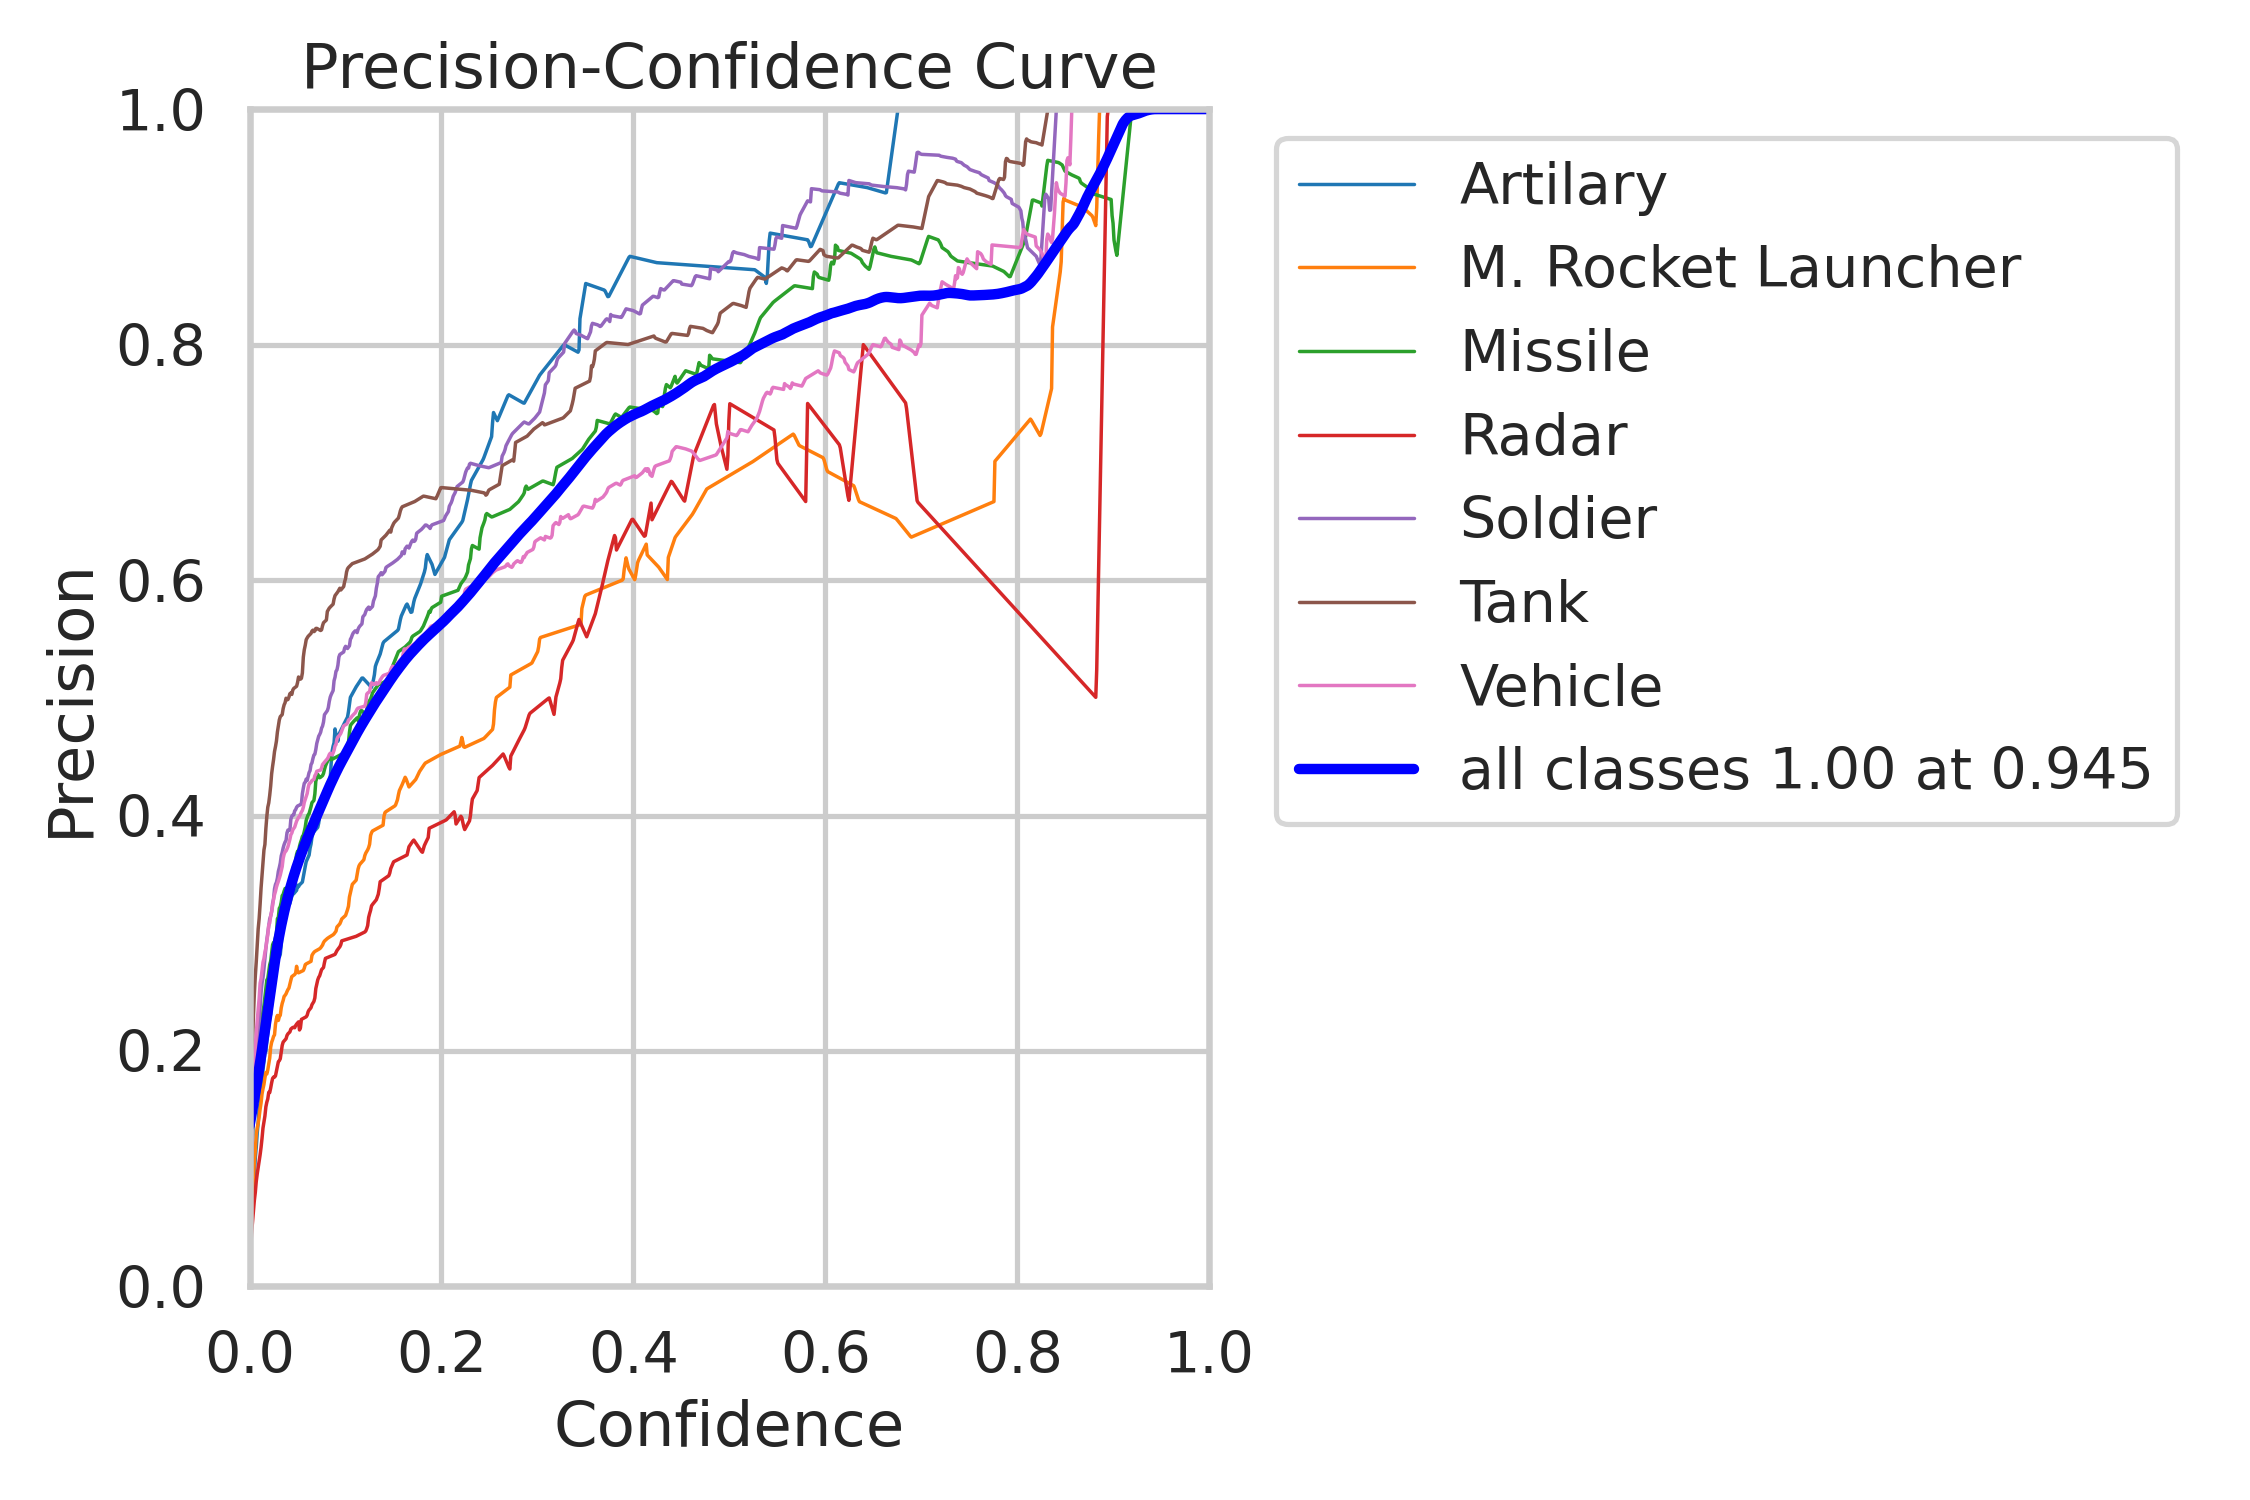

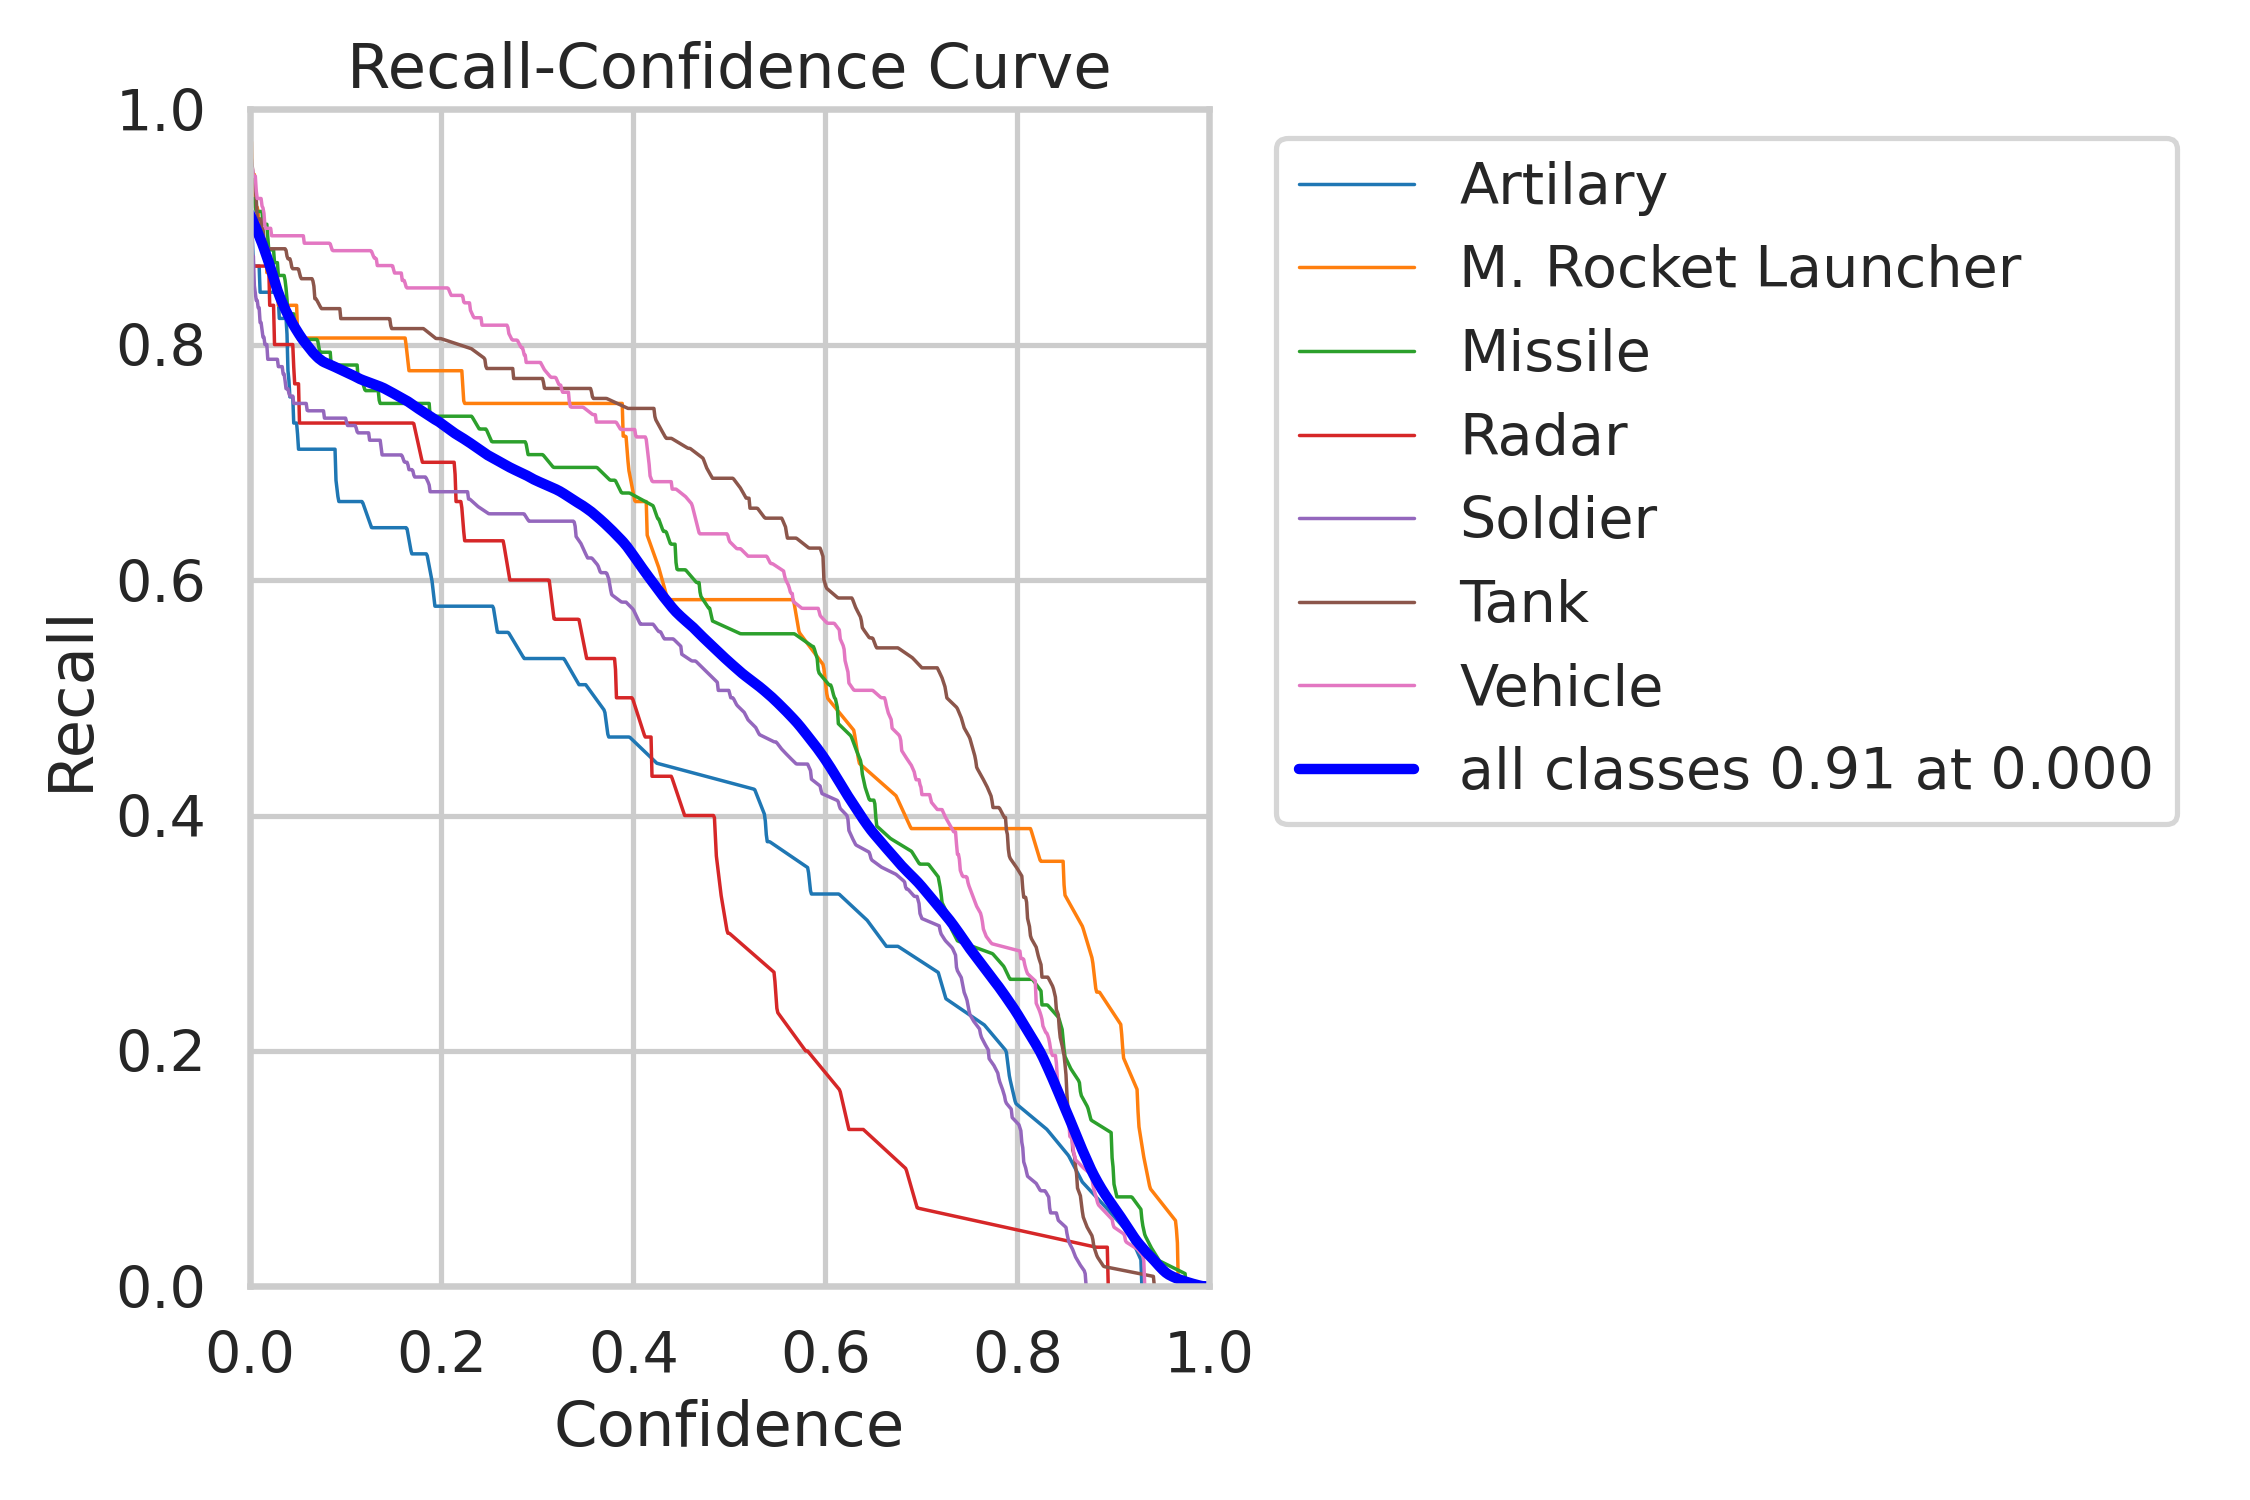

Run dir: runs/detect/yolov12s_drone


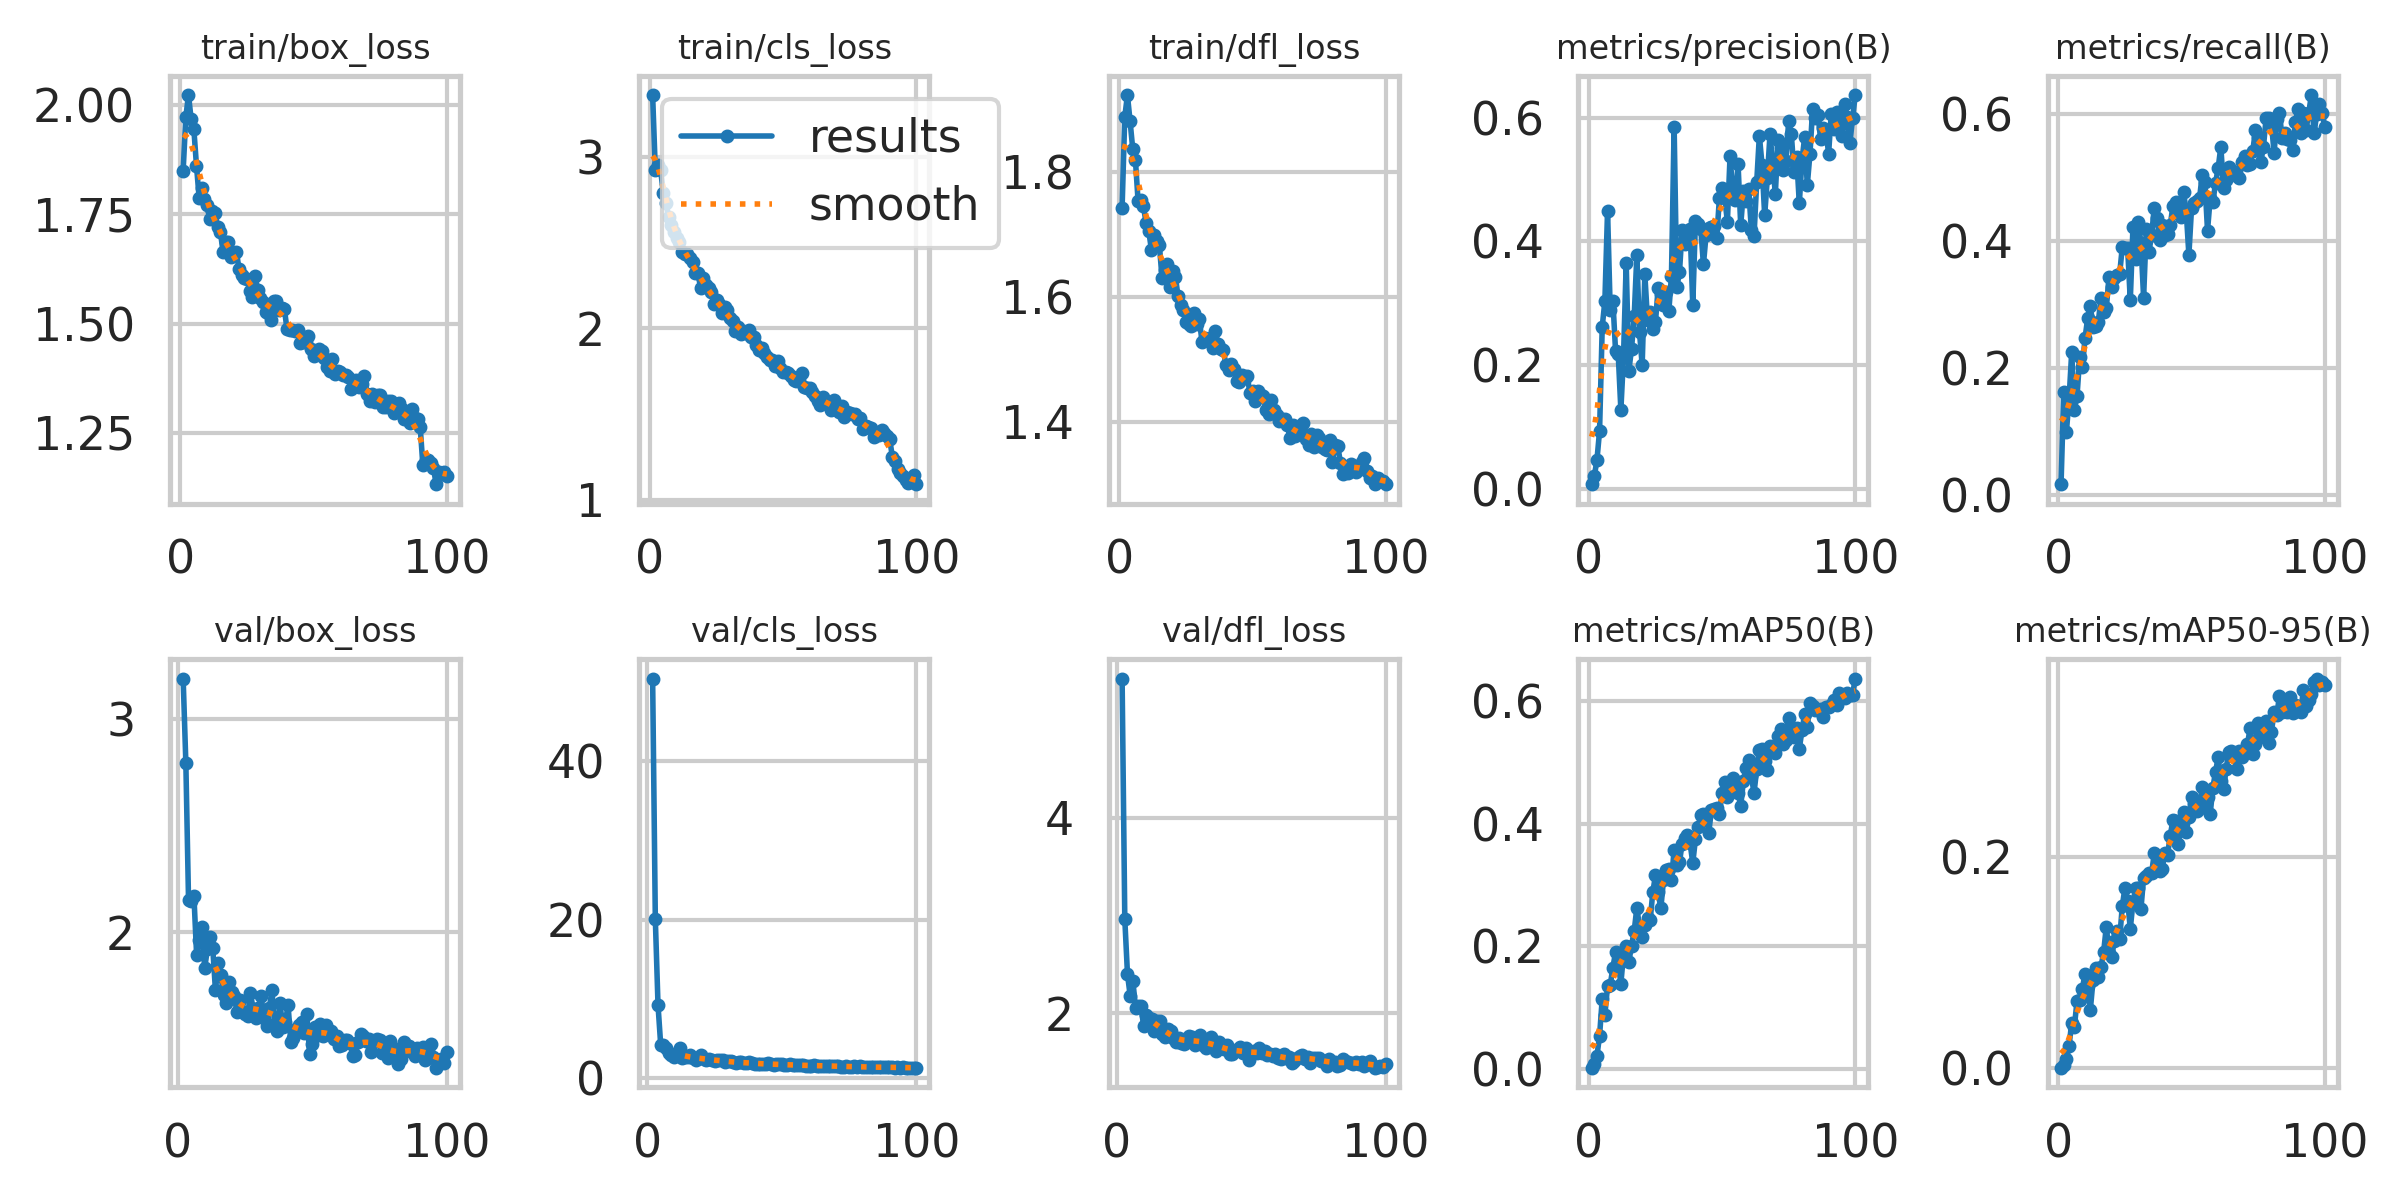

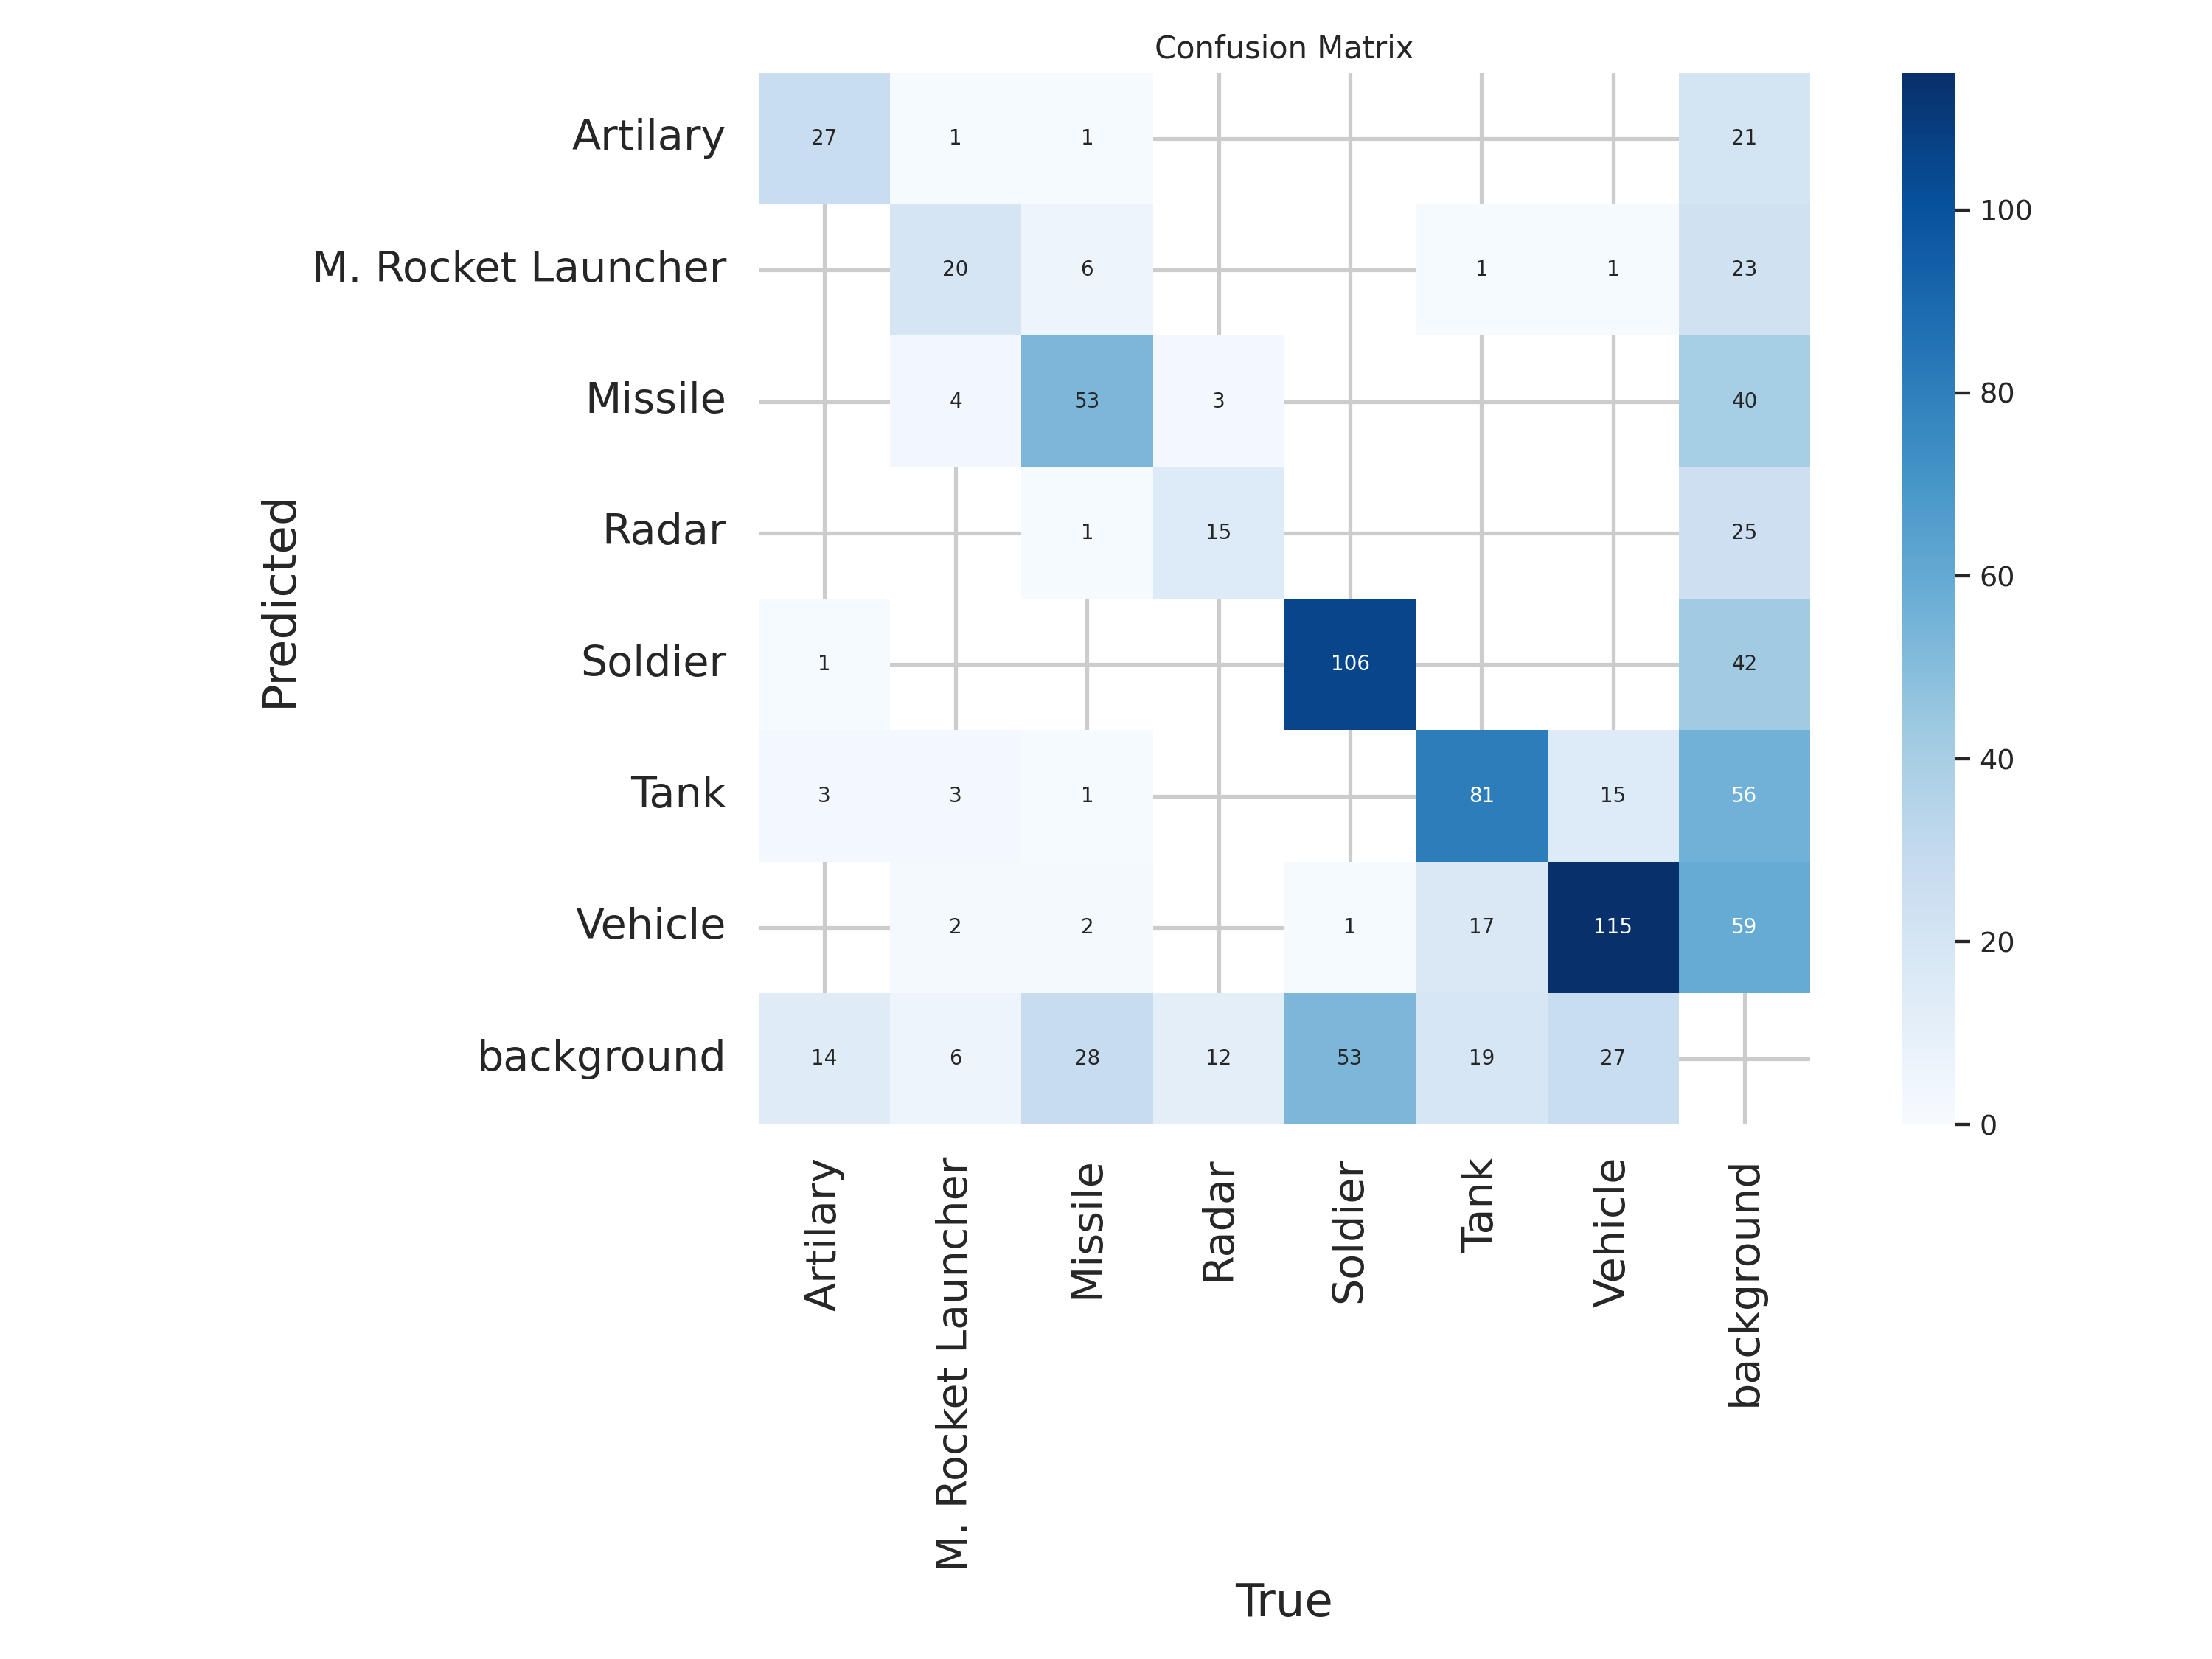

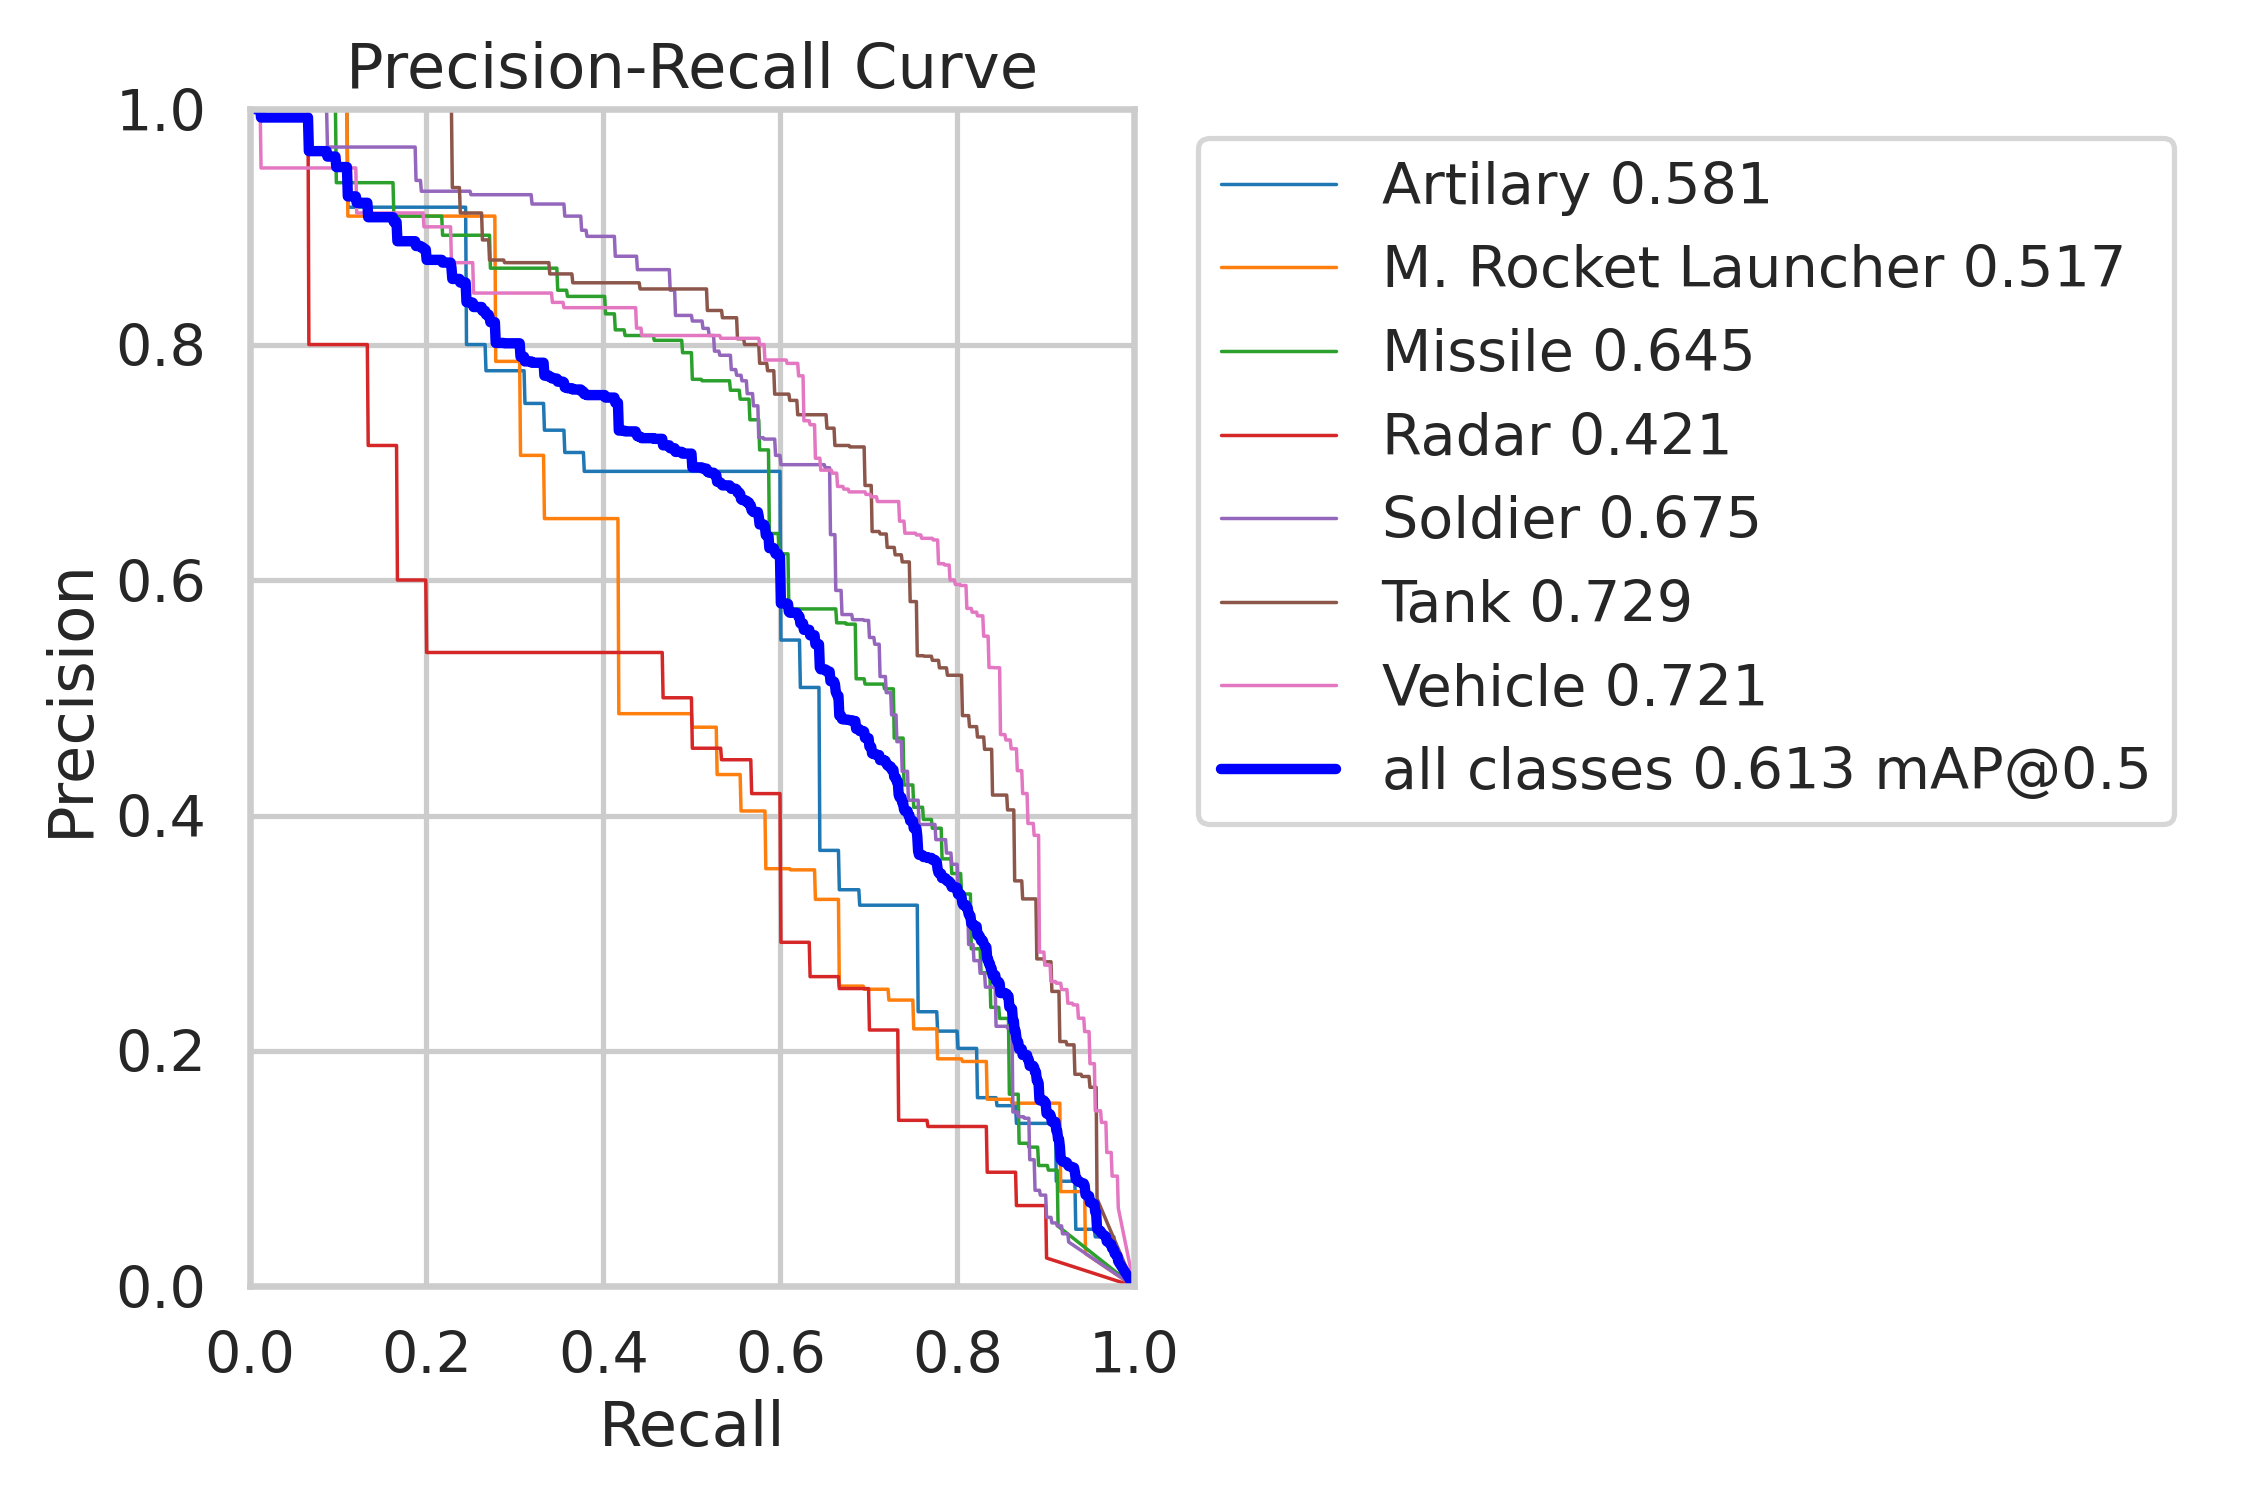

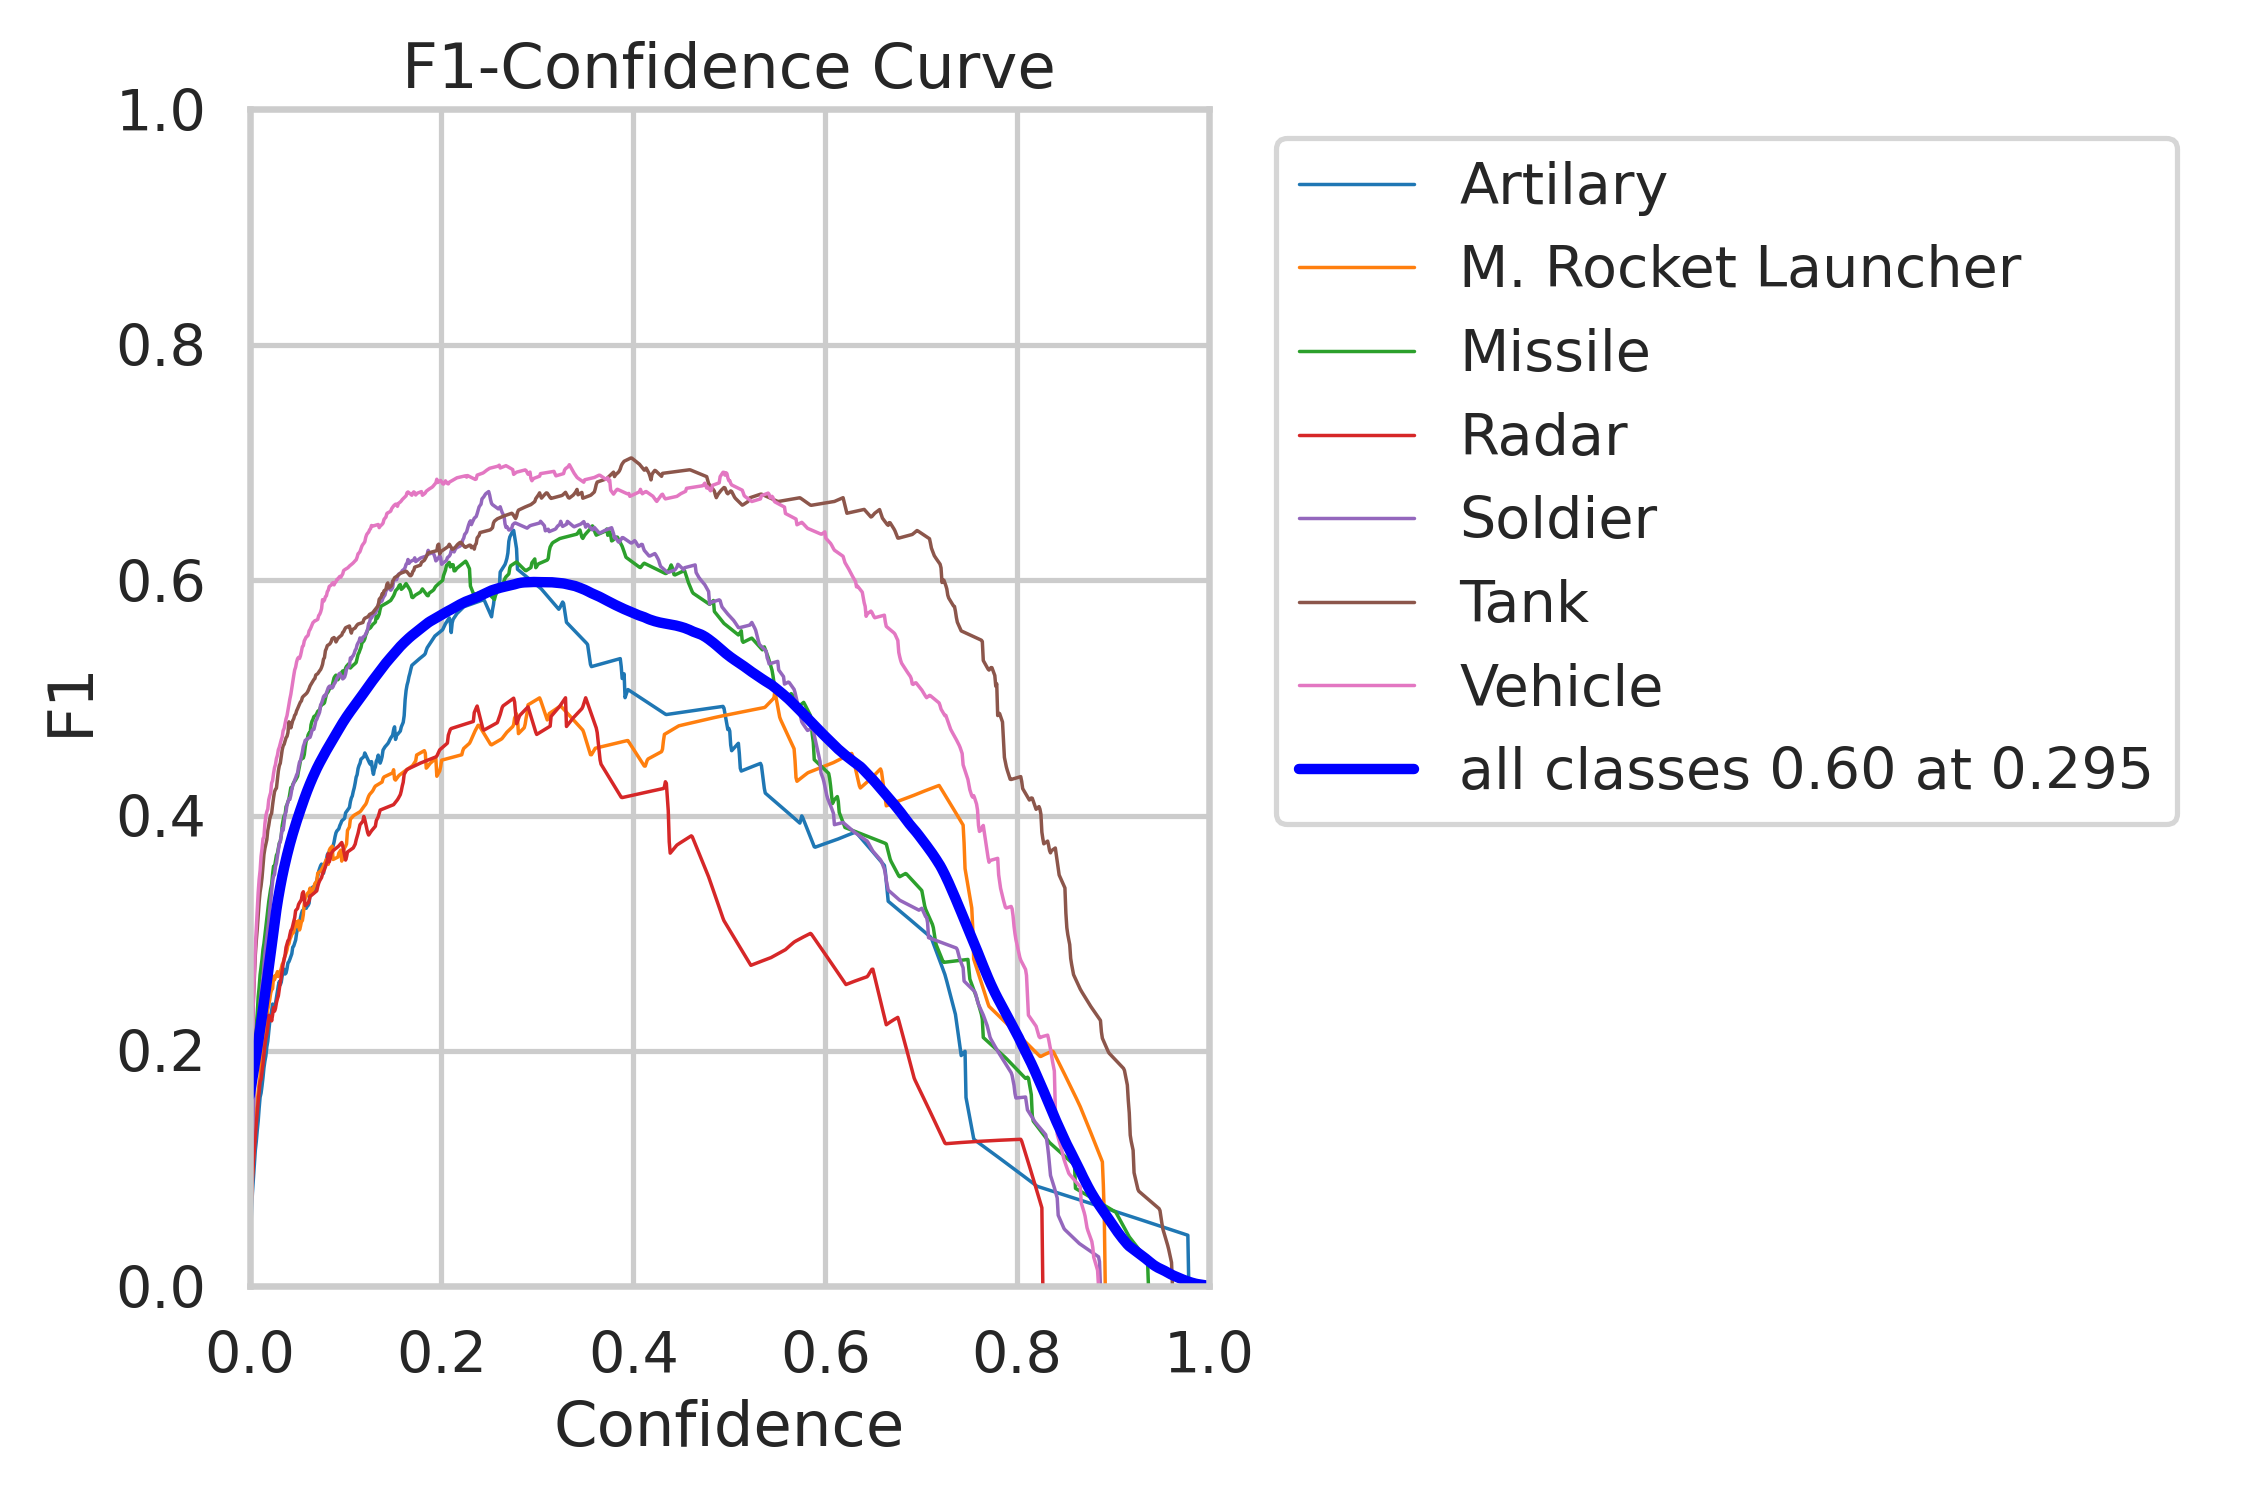

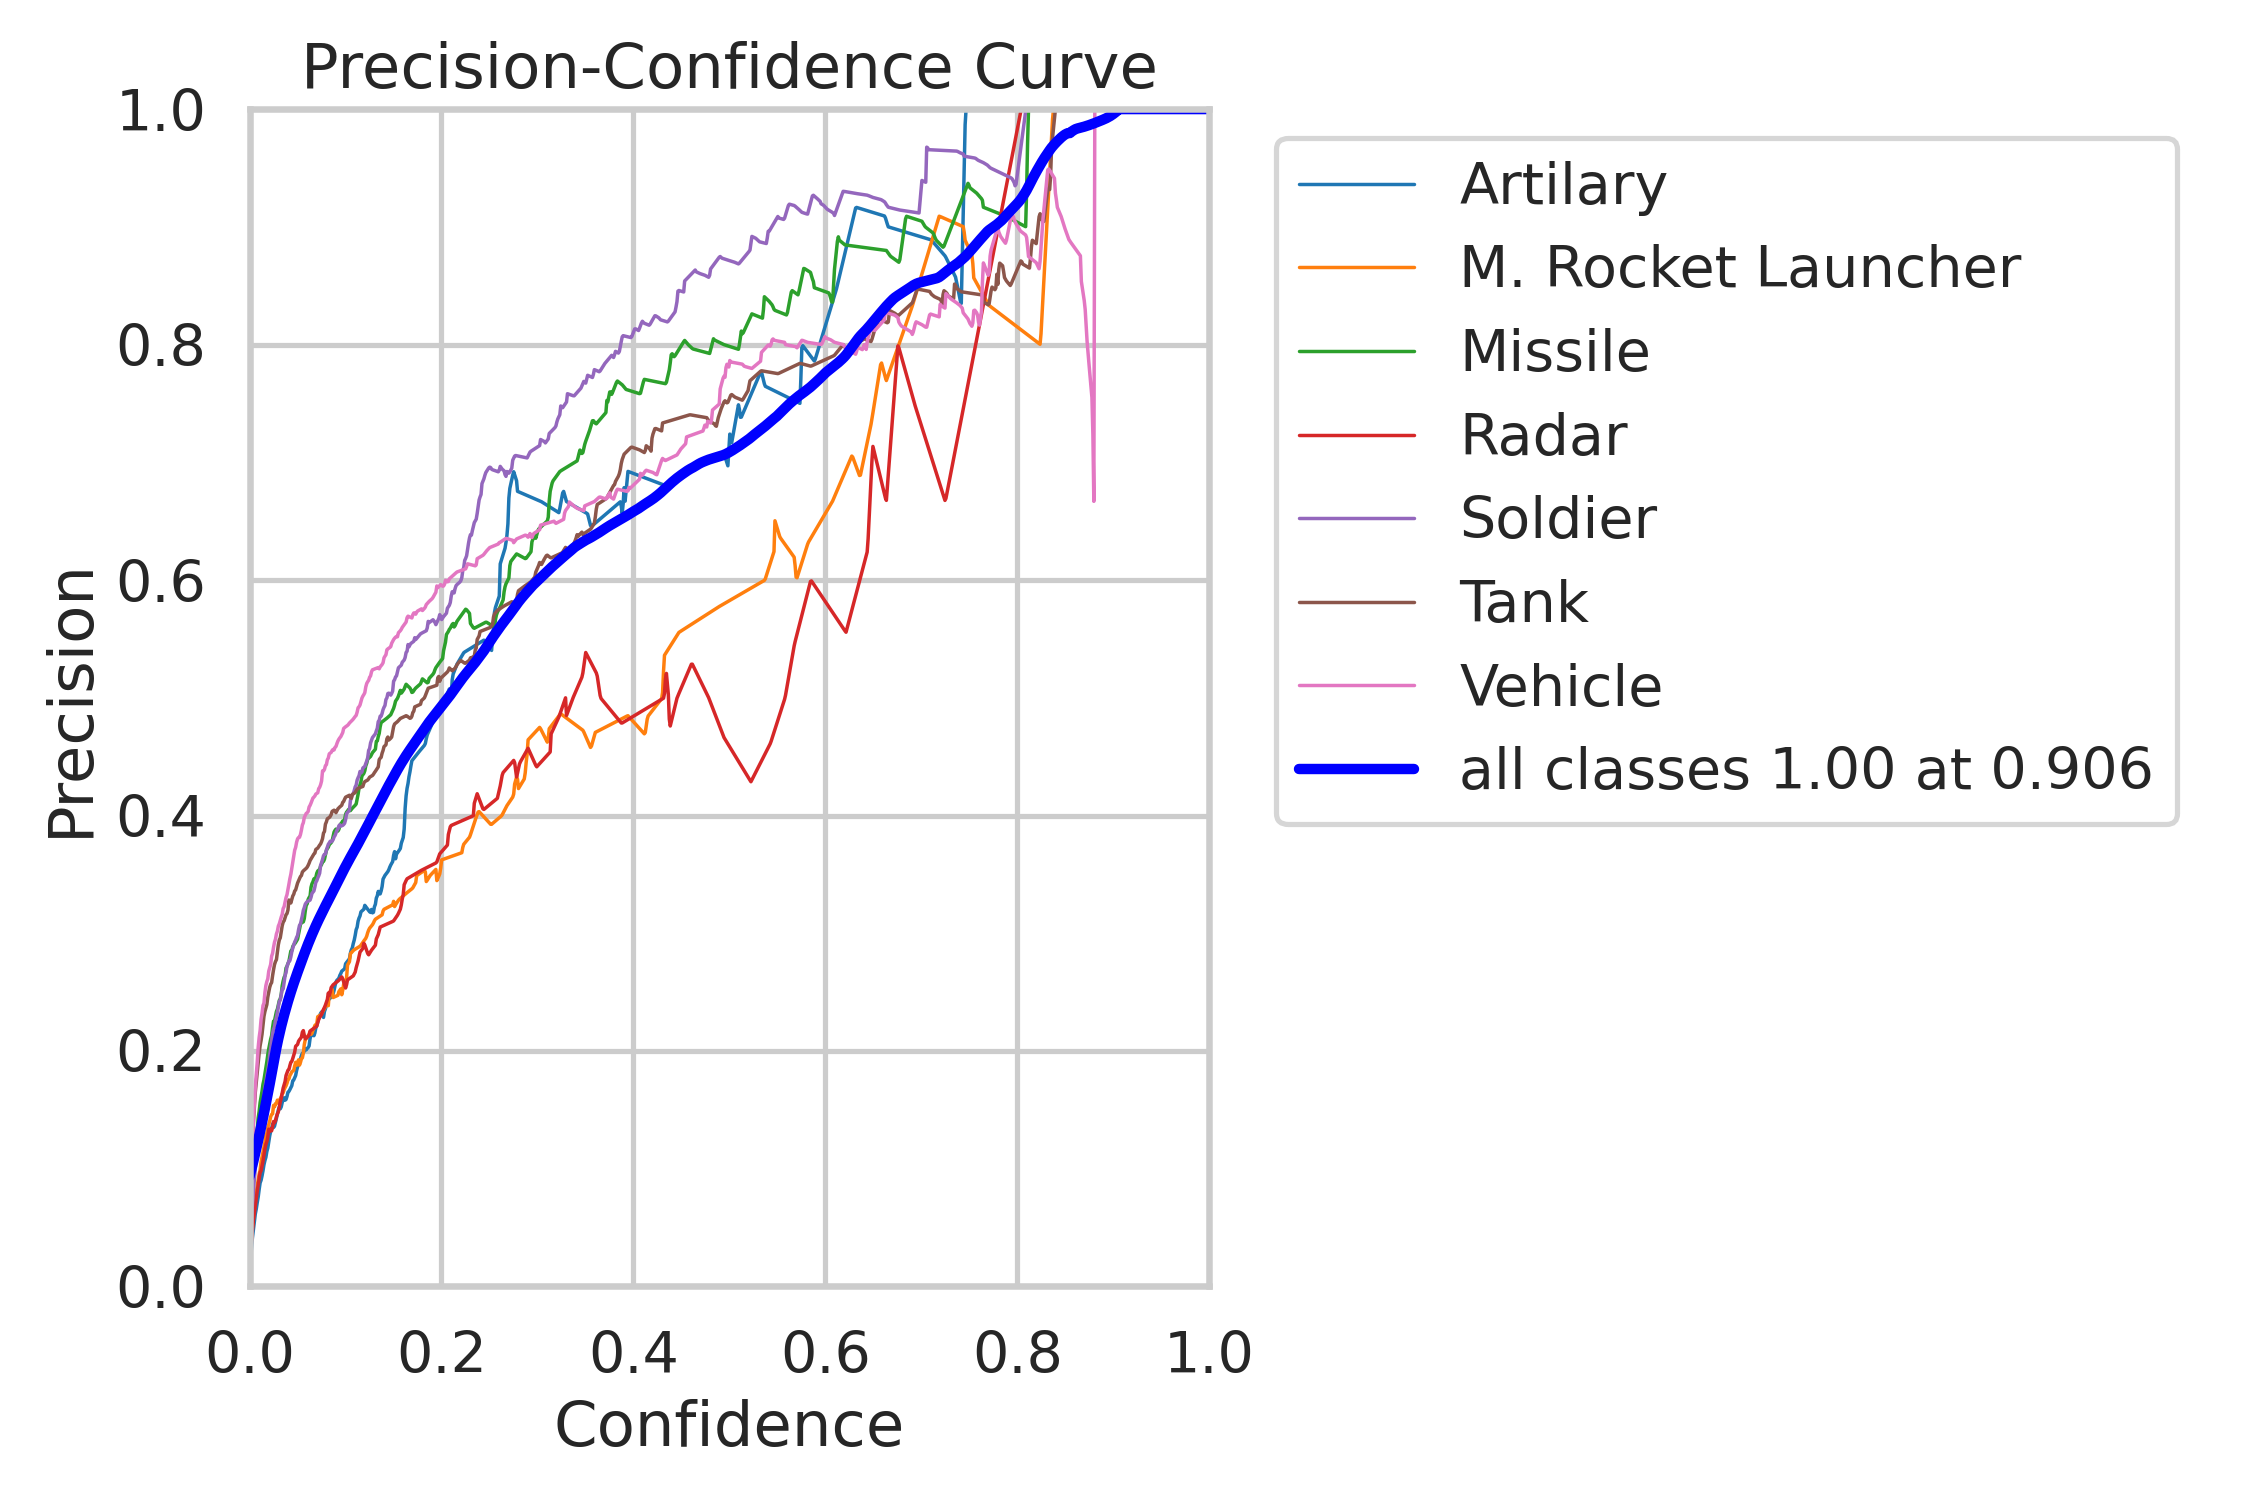

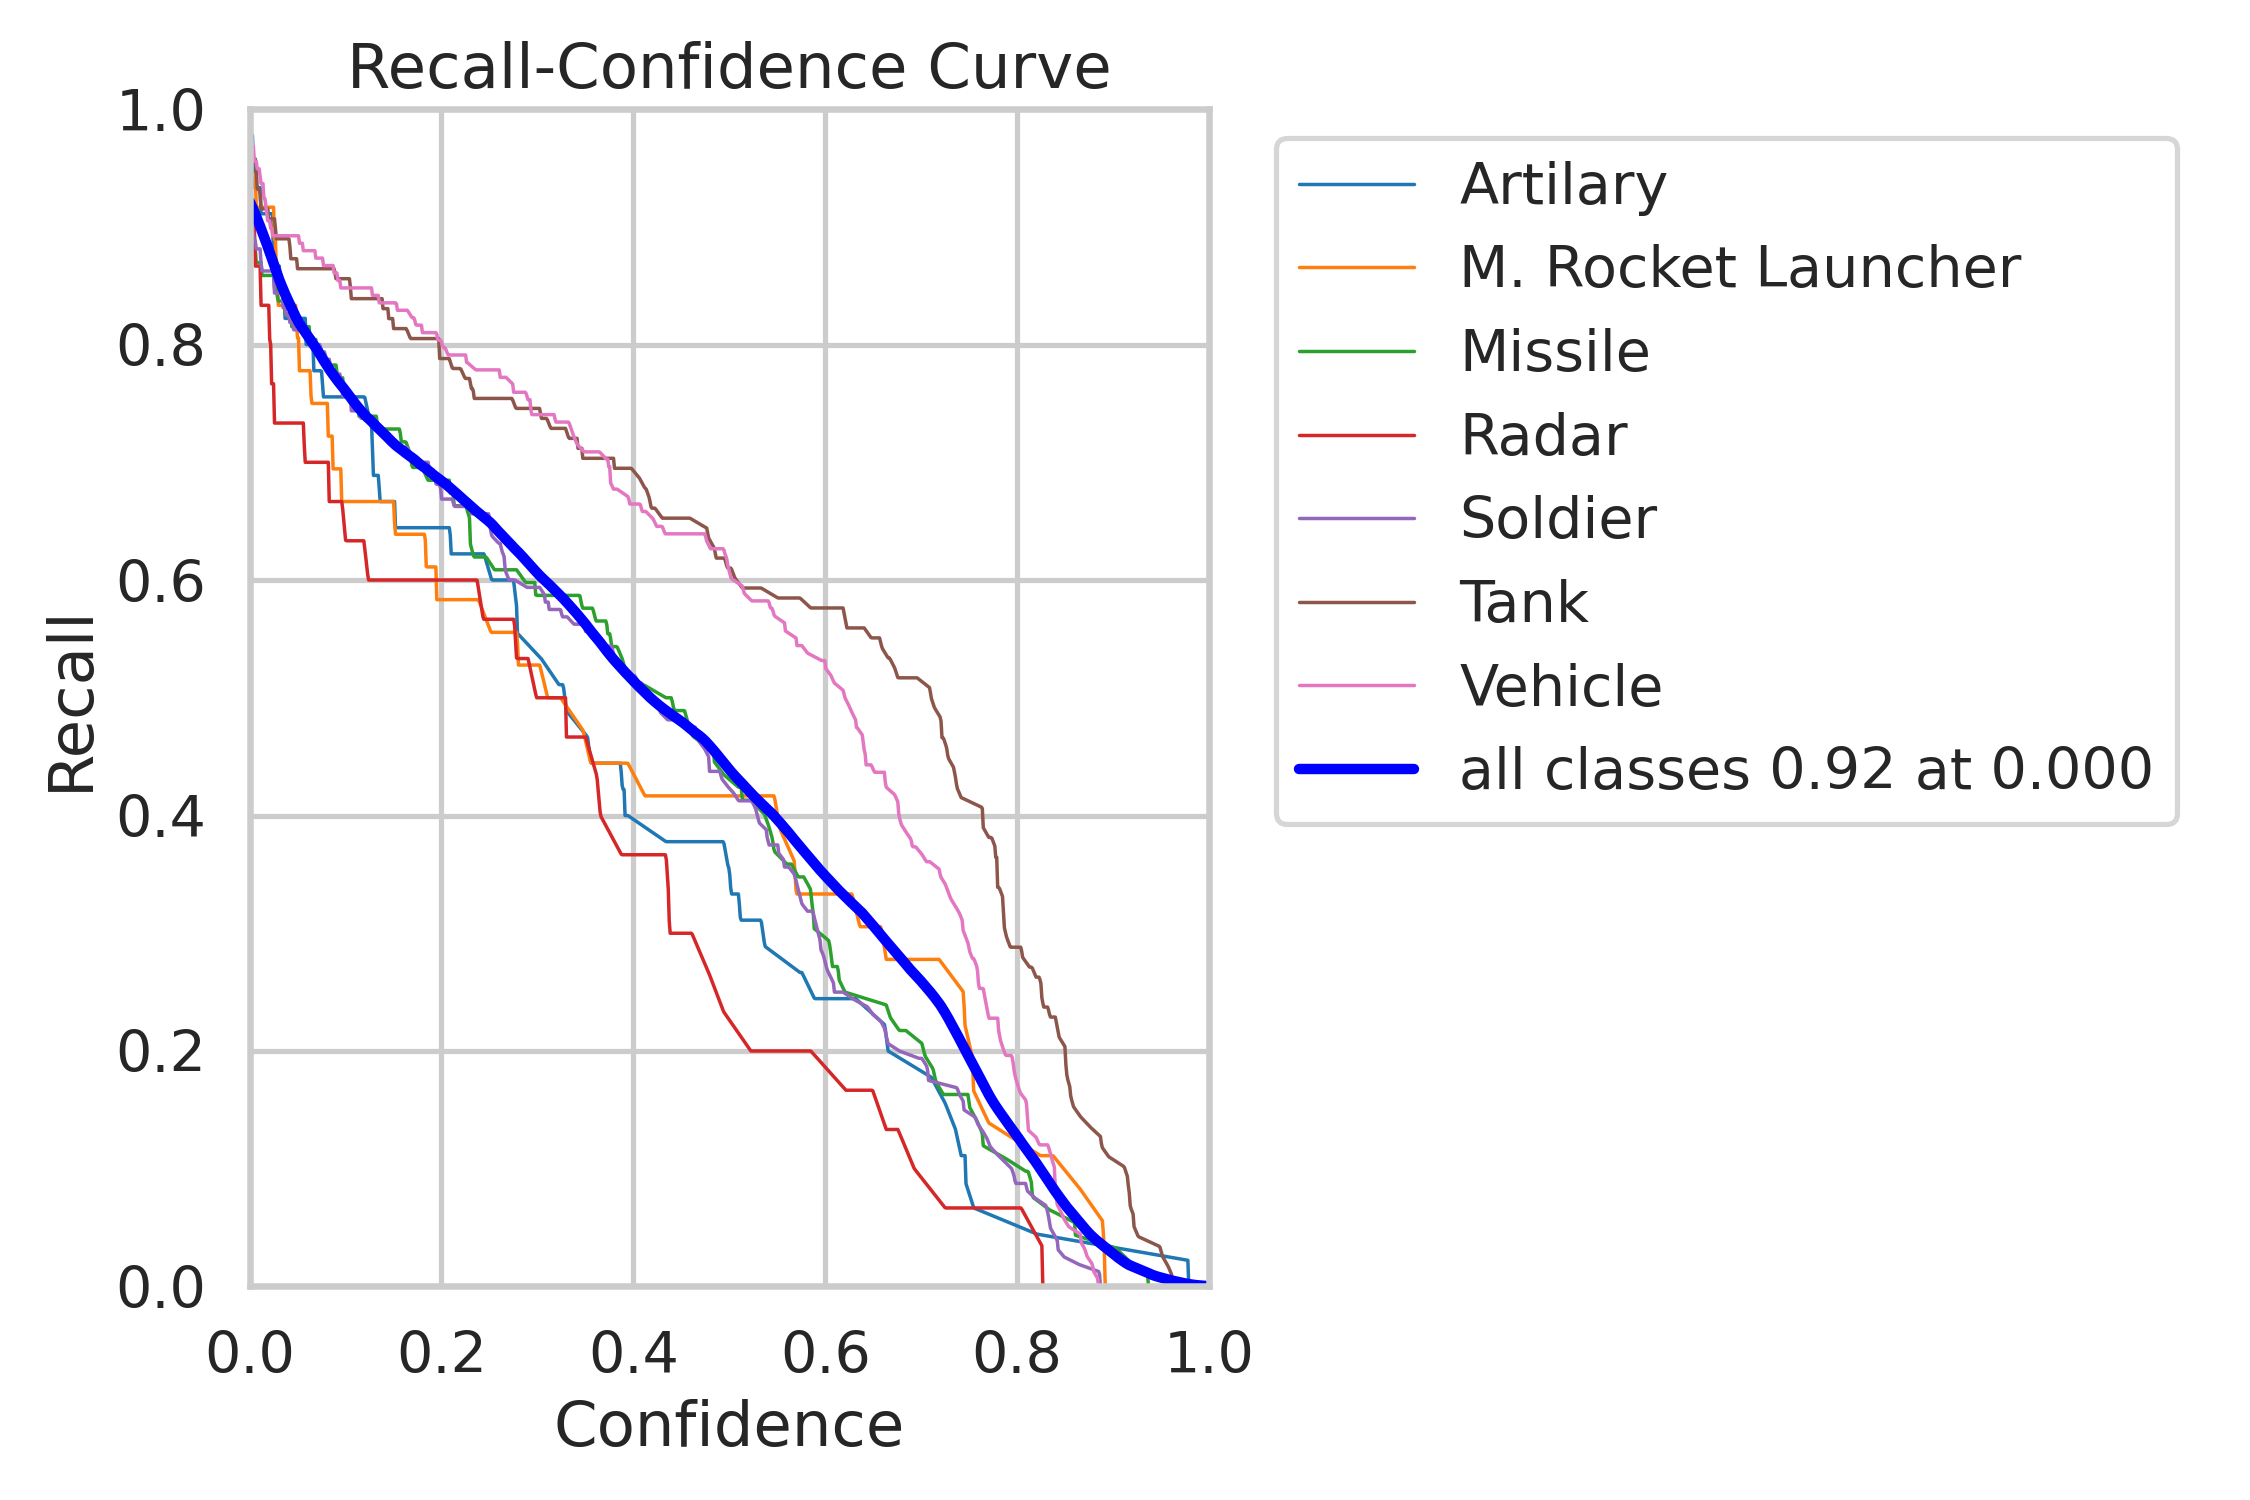

In [10]:

from IPython.display import Image, display
def show_run(run_name: str):
    rd = Path("runs/detect") / run_name
    print("Run dir:", rd)
    for f in ["results.png","confusion_matrix.png","PR_curve.png",
              "F1_curve.png","P_curve.png","R_curve.png"]:
        p = rd / f
        if p.exists():
            display(Image(filename=str(p)))

show_run(RUN8)
show_run(RUN12)


In [11]:

best8  = YOLO(str(Path("runs/detect") / RUN8  / "weights" / "best.pt"))
best12 = YOLO(str(Path("runs/detect") / RUN12 / "weights" / "best.pt"))

print("YOLOv8 Validation:")
m8 = best8.val(data=str(DATA_YAML), imgsz=IMGSZ, device=0, plots=True)

print("YOLOv12 Validation:")
m12 = best12.val(data=str(DATA_YAML), imgsz=IMGSZ, device=0, plots=True)


test_lbl_dir = YOLO_DATA / "labels/test"
if test_lbl_dir.exists() and any(test_lbl_dir.glob("*.txt")):
    print("\nEvaluating on TEST split (labels found):")
    data_test_yaml = YOLO_DATA / "data_test.yaml"
    with open(data_test_yaml, "w") as f:
        yaml.safe_dump({
            "path": str(YOLO_DATA),
            "train": "images/train",
            "val":   "images/val",
            "test":  "images/test",
            "names": classes
        }, f, sort_keys=False)
    _ = best8.val(data=str(data_test_yaml), split="test", imgsz=IMGSZ, device=0)
    _ = best12.val(data=str(data_test_yaml), split="test", imgsz=IMGSZ, device=0)
else:
    print("No test labels found; skipping test evaluation (we'll do predictions next).")


YOLOv8 Validation:
Ultralytics 8.3.78 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 11,128,293 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /kaggle/working/yolo_data/labels/val.cache... 229 images, 0 backgrounds, 0 corrupt: 100%|██████████| 229/229 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.68it/s]


                   all        229        639      0.697      0.653      0.685       0.41
              Artilary         28         45      0.819      0.504      0.661      0.326
    M. Rocket Launcher         29         36      0.574       0.75      0.667      0.493
               Missile         49         92      0.704      0.685      0.716      0.477
                 Radar         27         30      0.555      0.533      0.505      0.238
               Soldier         50        160      0.808      0.606      0.701      0.351
                  Tank         47        118      0.764      0.746      0.805      0.499
               Vehicle         69        158      0.655      0.744      0.741      0.488


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.9ms preprocess, 5.8ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/val
YOLOv12 Validation:
Ultralytics 8.3.78 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv12s summary (fused): 159 layers, 9,233,589 parameters, 0 gradients, 21.2 GFLOPs


val: Scanning /kaggle/working/yolo_data/labels/val.cache... 229 images, 0 backgrounds, 0 corrupt: 100%|██████████| 229/229 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


                   all        229        639      0.598      0.589      0.609      0.369
              Artilary         28         45       0.62      0.507      0.559       0.29
    M. Rocket Launcher         29         36      0.452      0.528      0.518      0.394
               Missile         49         92      0.669      0.587       0.64      0.425
                 Radar         27         30       0.44      0.446       0.41      0.185
               Soldier         50        160       0.74      0.586       0.69      0.355
                  Tank         47        118      0.617      0.729      0.727      0.443
               Vehicle         69        158      0.647      0.741      0.722      0.487


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 1.0ms preprocess, 6.9ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/detect/val2

Evaluating on TEST split (labels found):
Ultralytics 8.3.78 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


val: Scanning /kaggle/working/yolo_data/labels/test... 170 images, 0 backgrounds, 0 corrupt: 100%|██████████| 170/170 [00:00<00:00, 470.29it/s]

val: New cache created: /kaggle/working/yolo_data/labels/test.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.16it/s]


                   all        170        419      0.629      0.631      0.636      0.405
              Artilary         23         40      0.692      0.505      0.567      0.304
    M. Rocket Launcher         25         45      0.717      0.756      0.778      0.573
               Missile         23         36      0.558      0.611       0.59      0.446
                 Radar         31         34      0.499      0.471      0.379      0.205
               Soldier         36        120      0.625       0.65      0.621      0.306
                  Tank         34         58      0.646      0.691      0.748      0.467
               Vehicle         39         86      0.669      0.733       0.77      0.532


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 1.3ms preprocess, 4.4ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/val3
Ultralytics 8.3.78 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


val: Scanning /kaggle/working/yolo_data/labels/test.cache... 170 images, 0 backgrounds, 0 corrupt: 100%|██████████| 170/170 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.48it/s]


                   all        170        419      0.587      0.598      0.599      0.369
              Artilary         23         40      0.666      0.499      0.499      0.216
    M. Rocket Launcher         25         45      0.649      0.689      0.754      0.559
               Missile         23         36      0.574        0.5      0.527       0.36
                 Radar         31         34      0.441      0.471       0.38      0.219
               Soldier         36        120      0.532      0.636      0.592      0.285
                  Tank         34         58      0.576      0.741      0.719      0.443
               Vehicle         39         86      0.673      0.651      0.721      0.498


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 1.6ms preprocess, 7.4ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/val4


# Save the models

In [13]:
best_model_path = "/kaggle/working/results_v8/drone_yolov8/weights/best.pt"
print("Best model saved at:", best_model_path)


Best model saved at: /kaggle/working/results_v8/drone_yolov8/weights/best.pt


# Thank You.